In [1]:
import torch
import torch.nn as nn
import torch.nn.utils.rnn as rnn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

import numpy as np
import matplotlib.pyplot as plt
import sys

from Bio import SeqIO
from datetime import datetime

from torch.utils import data
#from data_generator import data_generator
from data_generator import Dataset
from lstm import LSTM_model
from lstm import LSTMCell
from time import sleep

In [2]:
def print_seq(preds, valid):
    for i, seq in enumerate(preds):
        print("Sequence {}".format(i))
        indexes = torch.argmax(seq[:valid[i]], dim=1)
        ret_val = [acids[x] for x in indexes]
        print("".join(ret_val))

In [3]:
acids = "ACDEFGHIKLMNOPQRSTUVWY-"
large_file = "uniref50.fasta"
small_file = "100k_rows.fasta"
test_file = "test.fasta"

max_seq_len = 2000

# Good sizes: 16/700 or 32/400 on laptop
# 32/1500 on desktop
batch_size = 32
hidden_dim = 300

hidden_layers = 1

# Use Cuda if available
use_cuda = torch.cuda.is_available() and True
print("Using GPU:", use_cuda)
processor = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True


# Initialising data generator
dataset = Dataset(small_file, max_seq_len, acids=acids)
base_generator = data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

# Initialising for training
#model = LSTMCell(len(acids), hidden_dim, hidden_layers, max_seq_len).to(processor)
model = LSTM_model(len(acids), hidden_dim, hidden_layers, max_seq_len, batch_size).to(processor)
loss_function = nn.CrossEntropyLoss(reduction="mean").to(processor)
#optimiser = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, nesterov=True)
optimiser = optim.Adam(model.parameters(), lr=2e-2, weight_decay=0.001)

Using GPU: True


In [4]:
# Initialising some variables for use in training
batches = 1000
time_diff = 0
no_improv = 0
min_loss = float("inf")
loss_list = []

print_stuff = False

# Main training loop
for i, (batch, labels, valid_elems) in enumerate(base_generator):

    # Keeping track of stuff
    start_time = datetime.now()
    sys.stdout.write("\rBatch: {0}. Min loss: {1:.5f}. Estimated time left: {2}. Batches since improvement: {3}.".format(i+1, min_loss, time_diff*(batches - i), no_improv))

    # Resetting gradients
    model.train()
    model.zero_grad()

    # Putting data on gpu 
    batch = batch.to(processor)
    labels = labels.to(processor)
    valid_elems = valid_elems.to(processor)    
    
    # Transposing from (batch x seq x feature_size) to (seq x batch x feature_size)
    batch = batch.transpose(0, 1)
    
    if i == 0 and print_stuff:
        print("Input:\t", batch.size())
        print("Labels:\t", labels.size())
        print("Valid:\t", valid_elems)
    batch = rnn.pack_padded_sequence(batch, valid_elems, enforce_sorted=False)
    #labels = rnn.pack_padded_sequence(labels, valid_elems, enforce_sorted=False, batch_first=True)

    out, hidden = model(batch)

    if i == 0 and print_stuff:
        print("Output:\t", out.data.size())
        print("Hidden:\t")#, hidden.size())

    # Backpropping only through the non-padded parts
    loss = 0
    for j in range(out.size()[1]):
        #print(out.size())
        #print(torch.narrow(out, 1, j, 1).squeeze(1).size())
        
        narrowed_out = torch.narrow(torch.narrow(out, 1, j, 1).squeeze(1), 0, 0, valid_elems[j])
        narrowed_labels = torch.narrow(labels[j], 0, 0, valid_elems[j])

        #print_seq(narrowed_out[0].view(1,2000,23))
        
        #print(narrowed_out.size())
        #print(narrowed_labels.size())
        loss += loss_function(narrowed_out, narrowed_labels)
        
    #loss /= out.size()[1]

    loss_list.append(loss.item())
    loss.backward()
    optimiser.step()

    if loss.item() < min_loss:
        torch.save(model.state_dict(), "model.pth")
        min_loss = loss.item()
        no_improv = 0
    else:
        no_improv += 1
        
    
    
    # For tracking progress
    end_time = datetime.now()
    time_diff = end_time - start_time
    
    # Breaking when it's run through the given number of batches
    if i+1 >= batches:
        break

Batch: 1. Min loss: inf. Estimated time left: 0. Batches since improvement: 0.

Batch: 2. Min loss: 100.61317. Estimated time left: 0:07:54.121404. Batches since improvement: 0.

Batch: 3. Min loss: 96.37365. Estimated time left: 0:07:11.634002. Batches since improvement: 0.

Batch: 4. Min loss: 96.37365. Estimated time left: 0:06:11.831150. Batches since improvement: 1.

Batch: 5. Min loss: 96.37365. Estimated time left: 0:07:24.951048. Batches since improvement: 2.

Batch: 6. Min loss: 96.37365. Estimated time left: 0:05:46.692825. Batches since improvement: 3.

Batch: 7. Min loss: 96.37365. Estimated time left: 0:06:25.305214. Batches since improvement: 4.

Batch: 8. Min loss: 96.37365. Estimated time left: 0:06:07.233246. Batches since improvement: 5.

Batch: 9. Min loss: 96.37365. Estimated time left: 0:06:45.431392. Batches since improvement: 6.

Batch: 10. Min loss: 95.93438. Estimated time left: 0:06:53.126098. Batches since improvement: 0.

Batch: 11. Min loss: 94.97475. Estimated time left: 0:06:15.128820. Batches since improvement: 0.

Batch: 12. Min loss: 94.16482. Estimated time left: 0:07:08.072826. Batches since improvement: 0.

Batch: 13. Min loss: 94.01957. Estimated time left: 0:07:18.618648. Batches since improvement: 0.

Batch: 14. Min loss: 93.76088. Estimated time left: 0:07:55.075671. Batches since improvement: 0.

Batch: 15. Min loss: 93.55705. Estimated time left: 0:08:18.115368. Batches since improvement: 0.

Batch: 16. Min loss: 93.30730. Estimated time left: 0:06:34.322095. Batches since improvement: 0.

Batch: 17. Min loss: 93.24947. Estimated time left: 0:07:09.293616. Batches since improvement: 0.

Batch: 18. Min loss: 93.24947. Estimated time left: 0:06:54.426902. Batches since improvement: 1.

Batch: 19. Min loss: 93.24947. Estimated time left: 0:05:39.063978. Batches since improvement: 2.

Batch: 20. Min loss: 93.24947. Estimated time left: 0:07:32.499984. Batches since improvement: 3.

Batch: 21. Min loss: 93.24947. Estimated time left: 0:06:06.425920. Batches since improvement: 4.

Batch: 22. Min loss: 93.24947. Estimated time left: 0:05:51.678338. Batches since improvement: 5.

Batch: 23. Min loss: 93.24947. Estimated time left: 0:05:15.098886. Batches since improvement: 6.

Batch: 24. Min loss: 93.24947. Estimated time left: 0:05:53.405325. Batches since improvement: 7.

Batch: 25. Min loss: 93.24947. Estimated time left: 0:06:17.043440. Batches since improvement: 8.

Batch: 26. Min loss: 93.01881. Estimated time left: 0:05:53.864550. Batches since improvement: 0.

Batch: 27. Min loss: 93.01232. Estimated time left: 0:06:57.066800. Batches since improvement: 0.

Batch: 28. Min loss: 93.01232. Estimated time left: 0:06:05.795458. Batches since improvement: 1.

Batch: 29. Min loss: 93.01232. Estimated time left: 0:06:49.105080. Batches since improvement: 2.

Batch: 30. Min loss: 93.01232. Estimated time left: 0:05:49.631854. Batches since improvement: 3.

Batch: 31. Min loss: 92.94312. Estimated time left: 0:06:21.166350. Batches since improvement: 0.

Batch: 32. Min loss: 92.77835. Estimated time left: 0:07:25.761318. Batches since improvement: 0.

Batch: 33. Min loss: 92.77835. Estimated time left: 0:05:45.287536. Batches since improvement: 1.

Batch: 34. Min loss: 92.72395. Estimated time left: 0:06:21.250387. Batches since improvement: 0.

Batch: 35. Min loss: 92.72395. Estimated time left: 0:06:22.785228. Batches since improvement: 1.

Batch: 36. Min loss: 92.72395. Estimated time left: 0:07:10.395790. Batches since improvement: 2.

Batch: 37. Min loss: 92.72395. Estimated time left: 0:06:24.324628. Batches since improvement: 3.

Batch: 38. Min loss: 92.72395. Estimated time left: 0:05:50.038944. Batches since improvement: 4.

Batch: 39. Min loss: 92.72395. Estimated time left: 0:06:03.914018. Batches since improvement: 5.

Batch: 40. Min loss: 92.52745. Estimated time left: 0:06:13.385979. Batches since improvement: 0.

Batch: 41. Min loss: 92.52745. Estimated time left: 0:05:34.633920. Batches since improvement: 1.

Batch: 42. Min loss: 92.52745. Estimated time left: 0:07:56.543403. Batches since improvement: 2.

Batch: 43. Min loss: 92.52745. Estimated time left: 0:06:18.857386. Batches since improvement: 3.

Batch: 44. Min loss: 92.52745. Estimated time left: 0:07:55.518945. Batches since improvement: 4.

Batch: 45. Min loss: 92.52745. Estimated time left: 0:06:16.324620. Batches since improvement: 5.

Batch: 46. Min loss: 92.52745. Estimated time left: 0:07:22.174550. Batches since improvement: 6.

Batch: 47. Min loss: 92.52745. Estimated time left: 0:07:34.308156. Batches since improvement: 7.

Batch: 48. Min loss: 92.52745. Estimated time left: 0:06:48.861778. Batches since improvement: 8.

Batch: 49. Min loss: 92.52745. Estimated time left: 0:07:06.737808. Batches since improvement: 9.

Batch: 50. Min loss: 92.52745. Estimated time left: 0:06:53.829552. Batches since improvement: 10.

Batch: 51. Min loss: 92.52745. Estimated time left: 0:05:57.640800. Batches since improvement: 11.

Batch: 52. Min loss: 92.52745. Estimated time left: 0:05:38.700947. Batches since improvement: 12.

Batch: 53. Min loss: 92.52745. Estimated time left: 0:05:59.410500. Batches since improvement: 13.

Batch: 54. Min loss: 92.52745. Estimated time left: 0:05:36.524026. Batches since improvement: 14.

Batch: 55. Min loss: 92.52745. Estimated time left: 0:06:04.530694. Batches since improvement: 15.

Batch: 56. Min loss: 92.52745. Estimated time left: 0:06:13.801365. Batches since improvement: 16.

Batch: 57. Min loss: 92.52745. Estimated time left: 0:04:59.615216. Batches since improvement: 17.

Batch: 58. Min loss: 92.52745. Estimated time left: 0:05:33.316552. Batches since improvement: 18.

Batch: 59. Min loss: 92.52745. Estimated time left: 0:05:40.690314. Batches since improvement: 19.

Batch: 60. Min loss: 92.52745. Estimated time left: 0:06:35.437371. Batches since improvement: 20.

Batch: 61. Min loss: 92.10685. Estimated time left: 0:06:37.963100. Batches since improvement: 0.

Batch: 62. Min loss: 92.10685. Estimated time left: 0:07:07.405569. Batches since improvement: 1.

Batch: 63. Min loss: 92.10685. Estimated time left: 0:07:53.723768. Batches since improvement: 2.

Batch: 64. Min loss: 92.10685. Estimated time left: 0:07:07.503439. Batches since improvement: 3.

Batch: 65. Min loss: 92.10685. Estimated time left: 0:07:32.592504. Batches since improvement: 4.

Batch: 66. Min loss: 92.10685. Estimated time left: 0:06:14.564740. Batches since improvement: 5.

Batch: 67. Min loss: 92.10685. Estimated time left: 0:05:26.132252. Batches since improvement: 6.

Batch: 68. Min loss: 92.10685. Estimated time left: 0:05:14.236266. Batches since improvement: 7.

Batch: 69. Min loss: 92.10685. Estimated time left: 0:07:08.244680. Batches since improvement: 8.

Batch: 70. Min loss: 91.76363. Estimated time left: 0:06:12.495893. Batches since improvement: 0.

Batch: 71. Min loss: 91.76363. Estimated time left: 0:06:35.033310. Batches since improvement: 1.

Batch: 72. Min loss: 91.76363. Estimated time left: 0:05:17.040759. Batches since improvement: 2.

Batch: 73. Min loss: 91.76363. Estimated time left: 0:06:03.761152. Batches since improvement: 3.

Batch: 74. Min loss: 91.76363. Estimated time left: 0:06:08.618769. Batches since improvement: 4.

Batch: 75. Min loss: 91.76363. Estimated time left: 0:05:18.106928. Batches since improvement: 5.

Batch: 76. Min loss: 91.76363. Estimated time left: 0:06:23.011050. Batches since improvement: 6.

Batch: 77. Min loss: 91.76363. Estimated time left: 0:05:44.689884. Batches since improvement: 7.

Batch: 78. Min loss: 91.76363. Estimated time left: 0:05:45.196462. Batches since improvement: 8.

Batch: 79. Min loss: 91.76363. Estimated time left: 0:07:34.427984. Batches since improvement: 9.

Batch: 80. Min loss: 91.76363. Estimated time left: 0:05:53.511114. Batches since improvement: 10.

Batch: 81. Min loss: 91.76363. Estimated time left: 0:06:54.498640. Batches since improvement: 11.

Batch: 82. Min loss: 91.76363. Estimated time left: 0:06:02.380080. Batches since improvement: 12.

Batch: 83. Min loss: 91.76363. Estimated time left: 0:07:28.157502. Batches since improvement: 13.

Batch: 84. Min loss: 91.76363. Estimated time left: 0:06:20.587095. Batches since improvement: 14.

Batch: 85. Min loss: 91.76363. Estimated time left: 0:05:51.779724. Batches since improvement: 15.

Batch: 86. Min loss: 91.76363. Estimated time left: 0:06:52.313640. Batches since improvement: 16.

Batch: 87. Min loss: 91.76363. Estimated time left: 0:06:30.627148. Batches since improvement: 17.

Batch: 88. Min loss: 91.76363. Estimated time left: 0:05:22.575682. Batches since improvement: 18.

Batch: 89. Min loss: 91.76363. Estimated time left: 0:05:27.867648. Batches since improvement: 19.

Batch: 90. Min loss: 91.76363. Estimated time left: 0:07:46.499414. Batches since improvement: 20.

Batch: 91. Min loss: 91.76363. Estimated time left: 0:07:02.618560. Batches since improvement: 21.

Batch: 92. Min loss: 91.76363. Estimated time left: 0:06:16.032393. Batches since improvement: 22.

Batch: 93. Min loss: 91.76363. Estimated time left: 0:05:32.078300. Batches since improvement: 23.

Batch: 94. Min loss: 91.76363. Estimated time left: 0:06:23.784352. Batches since improvement: 24.

Batch: 95. Min loss: 91.76363. Estimated time left: 0:05:43.285212. Batches since improvement: 25.

Batch: 96. Min loss: 91.76363. Estimated time left: 0:06:48.306135. Batches since improvement: 26.

Batch: 97. Min loss: 91.76363. Estimated time left: 0:07:23.561160. Batches since improvement: 27.

Batch: 98. Min loss: 91.76363. Estimated time left: 0:06:47.915802. Batches since improvement: 28.

Batch: 99. Min loss: 91.76363. Estimated time left: 0:06:19.476812. Batches since improvement: 29.

Batch: 100. Min loss: 91.76363. Estimated time left: 0:05:53.701065. Batches since improvement: 30.

Batch: 101. Min loss: 91.76363. Estimated time left: 0:07:05.925000. Batches since improvement: 31.

Batch: 102. Min loss: 91.76363. Estimated time left: 0:05:21.304398. Batches since improvement: 32.

Batch: 103. Min loss: 91.76363. Estimated time left: 0:05:55.924096. Batches since improvement: 33.

Batch: 104. Min loss: 91.76363. Estimated time left: 0:07:18.564828. Batches since improvement: 34.

Batch: 105. Min loss: 91.76363. Estimated time left: 0:05:48.402432. Batches since improvement: 35.

Batch: 106. Min loss: 91.76363. Estimated time left: 0:05:34.541155. Batches since improvement: 36.

Batch: 107. Min loss: 91.76363. Estimated time left: 0:07:24.478026. Batches since improvement: 37.

Batch: 108. Min loss: 91.76363. Estimated time left: 0:06:11.668386. Batches since improvement: 38.

Batch: 109. Min loss: 91.76363. Estimated time left: 0:06:56.531888. Batches since improvement: 39.

Batch: 110. Min loss: 91.76363. Estimated time left: 0:06:39.003165. Batches since improvement: 40.

Batch: 111. Min loss: 91.76363. Estimated time left: 0:07:16.855610. Batches since improvement: 41.

Batch: 112. Min loss: 91.76363. Estimated time left: 0:07:08.061501. Batches since improvement: 42.

Batch: 113. Min loss: 91.76363. Estimated time left: 0:07:20.014656. Batches since improvement: 43.

Batch: 114. Min loss: 91.76363. Estimated time left: 0:05:49.441633. Batches since improvement: 44.

Batch: 115. Min loss: 91.76363. Estimated time left: 0:06:57.228918. Batches since improvement: 45.

Batch: 116. Min loss: 91.76363. Estimated time left: 0:05:22.555950. Batches since improvement: 46.

Batch: 117. Min loss: 91.76363. Estimated time left: 0:05:26.116440. Batches since improvement: 47.

Batch: 118. Min loss: 91.76363. Estimated time left: 0:06:41.178688. Batches since improvement: 48.

Batch: 119. Min loss: 91.76363. Estimated time left: 0:04:55.933050. Batches since improvement: 49.

Batch: 120. Min loss: 91.76363. Estimated time left: 0:05:12.282784. Batches since improvement: 50.

Batch: 121. Min loss: 91.76363. Estimated time left: 0:05:41.051920. Batches since improvement: 51.

Batch: 122. Min loss: 91.76363. Estimated time left: 0:05:48.716001. Batches since improvement: 52.

Batch: 123. Min loss: 91.76363. Estimated time left: 0:06:22.746540. Batches since improvement: 53.

Batch: 124. Min loss: 91.76363. Estimated time left: 0:06:30.880654. Batches since improvement: 54.

Batch: 125. Min loss: 91.76363. Estimated time left: 0:06:46.614672. Batches since improvement: 55.

Batch: 126. Min loss: 91.76363. Estimated time left: 0:06:31.991250. Batches since improvement: 56.

Batch: 127. Min loss: 91.76363. Estimated time left: 0:05:25.945190. Batches since improvement: 57.

Batch: 128. Min loss: 91.76363. Estimated time left: 0:06:59.940063. Batches since improvement: 58.

Batch: 129. Min loss: 91.76363. Estimated time left: 0:04:57.836832. Batches since improvement: 59.

Batch: 130. Min loss: 91.76363. Estimated time left: 0:05:21.612395. Batches since improvement: 60.

Batch: 131. Min loss: 91.76363. Estimated time left: 0:04:16.214130. Batches since improvement: 61.

Batch: 132. Min loss: 91.76363. Estimated time left: 0:06:35.855570. Batches since improvement: 62.

Batch: 133. Min loss: 91.76363. Estimated time left: 0:05:56.437256. Batches since improvement: 63.

Batch: 134. Min loss: 91.76363. Estimated time left: 0:05:54.401856. Batches since improvement: 64.

Batch: 135. Min loss: 91.76363. Estimated time left: 0:04:35.196614. Batches since improvement: 65.

Batch: 136. Min loss: 91.70553. Estimated time left: 0:05:28.414550. Batches since improvement: 0.

Batch: 137. Min loss: 91.70553. Estimated time left: 0:04:59.100384. Batches since improvement: 1.

Batch: 138. Min loss: 91.70553. Estimated time left: 0:06:11.857207. Batches since improvement: 2.

Batch: 139. Min loss: 91.70553. Estimated time left: 0:05:41.587326. Batches since improvement: 3.

Batch: 140. Min loss: 91.70553. Estimated time left: 0:06:57.747729. Batches since improvement: 4.

Batch: 141. Min loss: 91.70553. Estimated time left: 0:06:05.734780. Batches since improvement: 5.

Batch: 142. Min loss: 91.70553. Estimated time left: 0:05:41.624300. Batches since improvement: 6.

Batch: 143. Min loss: 91.70553. Estimated time left: 0:05:25.039572. Batches since improvement: 7.

Batch: 144. Min loss: 91.70553. Estimated time left: 0:06:56.630550. Batches since improvement: 8.

Batch: 145. Min loss: 91.70553. Estimated time left: 0:05:11.766328. Batches since improvement: 9.

Batch: 146. Min loss: 91.70553. Estimated time left: 0:05:52.879875. Batches since improvement: 10.

Batch: 147. Min loss: 91.70553. Estimated time left: 0:06:54.338596. Batches since improvement: 11.

Batch: 148. Min loss: 91.70553. Estimated time left: 0:04:47.865322. Batches since improvement: 12.

Batch: 149. Min loss: 91.70553. Estimated time left: 0:05:00.445020. Batches since improvement: 13.

Batch: 150. Min loss: 91.59489. Estimated time left: 0:04:52.196807. Batches since improvement: 0.

Batch: 151. Min loss: 91.05058. Estimated time left: 0:04:53.397050. Batches since improvement: 0.

Batch: 152. Min loss: 91.05058. Estimated time left: 0:05:21.035766. Batches since improvement: 1.

Batch: 153. Min loss: 91.05058. Estimated time left: 0:04:43.934144. Batches since improvement: 2.

Batch: 154. Min loss: 91.05058. Estimated time left: 0:05:22.444430. Batches since improvement: 3.

Batch: 155. Min loss: 91.05058. Estimated time left: 0:07:07.433040. Batches since improvement: 4.

Batch: 156. Min loss: 91.05058. Estimated time left: 0:05:55.392635. Batches since improvement: 5.

Batch: 157. Min loss: 91.05058. Estimated time left: 0:05:12.441204. Batches since improvement: 6.

Batch: 158. Min loss: 91.05058. Estimated time left: 0:06:19.811121. Batches since improvement: 7.

Batch: 159. Min loss: 91.05058. Estimated time left: 0:04:47.178414. Batches since improvement: 8.

Batch: 160. Min loss: 91.05058. Estimated time left: 0:04:35.569629. Batches since improvement: 9.

Batch: 161. Min loss: 91.05058. Estimated time left: 0:06:17.338920. Batches since improvement: 10.

Batch: 162. Min loss: 91.05058. Estimated time left: 0:05:33.468101. Batches since improvement: 11.

Batch: 163. Min loss: 91.05058. Estimated time left: 0:06:03.655128. Batches since improvement: 12.

Batch: 164. Min loss: 91.05058. Estimated time left: 0:05:01.735152. Batches since improvement: 13.

Batch: 165. Min loss: 91.05058. Estimated time left: 0:04:52.303220. Batches since improvement: 14.

Batch: 166. Min loss: 91.05058. Estimated time left: 0:06:27.683820. Batches since improvement: 15.

Batch: 167. Min loss: 91.05058. Estimated time left: 0:05:44.572104. Batches since improvement: 16.

Batch: 168. Min loss: 91.05058. Estimated time left: 0:05:14.268409. Batches since improvement: 17.

Batch: 169. Min loss: 91.05058. Estimated time left: 0:06:17.089024. Batches since improvement: 18.

Batch: 170. Min loss: 91.05058. Estimated time left: 0:05:29.653545. Batches since improvement: 19.

Batch: 171. Min loss: 91.05058. Estimated time left: 0:05:14.106030. Batches since improvement: 20.

Batch: 172. Min loss: 91.05058. Estimated time left: 0:04:55.162963. Batches since improvement: 21.

Batch: 173. Min loss: 91.05058. Estimated time left: 0:06:02.269872. Batches since improvement: 22.

Batch: 174. Min loss: 91.05058. Estimated time left: 0:06:55.063030. Batches since improvement: 23.

Batch: 175. Min loss: 91.05058. Estimated time left: 0:06:17.493564. Batches since improvement: 24.

Batch: 176. Min loss: 91.05058. Estimated time left: 0:05:07.881750. Batches since improvement: 25.

Batch: 177. Min loss: 91.05058. Estimated time left: 0:05:23.476856. Batches since improvement: 26.

Batch: 178. Min loss: 91.05058. Estimated time left: 0:06:10.696483. Batches since improvement: 27.

Batch: 179. Min loss: 91.05058. Estimated time left: 0:05:14.939436. Batches since improvement: 28.

Batch: 180. Min loss: 91.05058. Estimated time left: 0:06:46.236547. Batches since improvement: 29.

Batch: 181. Min loss: 91.05058. Estimated time left: 0:05:38.152420. Batches since improvement: 30.

Batch: 182. Min loss: 91.05058. Estimated time left: 0:04:44.369085. Batches since improvement: 31.

Batch: 183. Min loss: 91.05058. Estimated time left: 0:06:16.497588. Batches since improvement: 32.

Batch: 184. Min loss: 91.05058. Estimated time left: 0:06:40.182940. Batches since improvement: 33.

Batch: 185. Min loss: 91.05058. Estimated time left: 0:05:41.012112. Batches since improvement: 34.

Batch: 186. Min loss: 91.05058. Estimated time left: 0:06:17.913870. Batches since improvement: 35.

Batch: 187. Min loss: 91.05058. Estimated time left: 0:05:20.545874. Batches since improvement: 36.

Batch: 188. Min loss: 91.05058. Estimated time left: 0:06:16.105182. Batches since improvement: 37.

Batch: 189. Min loss: 91.05058. Estimated time left: 0:04:45.509756. Batches since improvement: 38.

Batch: 190. Min loss: 91.05058. Estimated time left: 0:06:24.649190. Batches since improvement: 39.

Batch: 191. Min loss: 91.05058. Estimated time left: 0:06:17.083350. Batches since improvement: 40.

Batch: 192. Min loss: 91.05058. Estimated time left: 0:04:04.306674. Batches since improvement: 41.

Batch: 193. Min loss: 91.05058. Estimated time left: 0:06:39.269968. Batches since improvement: 42.

Batch: 194. Min loss: 91.05058. Estimated time left: 0:05:02.595141. Batches since improvement: 43.

Batch: 195. Min loss: 91.05058. Estimated time left: 0:05:18.644846. Batches since improvement: 44.

Batch: 196. Min loss: 91.05058. Estimated time left: 0:05:00.747195. Batches since improvement: 45.

Batch: 197. Min loss: 91.05058. Estimated time left: 0:04:22.963476. Batches since improvement: 46.

Batch: 198. Min loss: 91.05058. Estimated time left: 0:05:48.398413. Batches since improvement: 47.

Batch: 199. Min loss: 91.05058. Estimated time left: 0:05:58.745026. Batches since improvement: 48.

Batch: 200. Min loss: 91.05058. Estimated time left: 0:06:14.357763. Batches since improvement: 49.

Batch: 201. Min loss: 91.05058. Estimated time left: 0:06:14.825600. Batches since improvement: 50.

Batch: 202. Min loss: 91.05058. Estimated time left: 0:04:37.090004. Batches since improvement: 51.

Batch: 203. Min loss: 91.05058. Estimated time left: 0:04:56.907072. Batches since improvement: 52.

Batch: 204. Min loss: 91.05058. Estimated time left: 0:06:06.453427. Batches since improvement: 53.

Batch: 205. Min loss: 91.05058. Estimated time left: 0:05:09.502312. Batches since improvement: 54.

Batch: 206. Min loss: 91.05058. Estimated time left: 0:05:27.047895. Batches since improvement: 55.

Batch: 207. Min loss: 91.05058. Estimated time left: 0:05:21.195232. Batches since improvement: 56.

Batch: 208. Min loss: 91.05058. Estimated time left: 0:05:25.662103. Batches since improvement: 57.

Batch: 209. Min loss: 91.05058. Estimated time left: 0:05:01.146912. Batches since improvement: 58.

Batch: 210. Min loss: 91.05058. Estimated time left: 0:05:13.739867. Batches since improvement: 59.

Batch: 211. Min loss: 91.05058. Estimated time left: 0:05:49.253470. Batches since improvement: 60.

Batch: 212. Min loss: 91.05058. Estimated time left: 0:04:35.660031. Batches since improvement: 61.

Batch: 213. Min loss: 91.05058. Estimated time left: 0:05:11.149680. Batches since improvement: 62.

Batch: 214. Min loss: 91.05058. Estimated time left: 0:06:20.662456. Batches since improvement: 63.

Batch: 215. Min loss: 91.05058. Estimated time left: 0:04:43.651680. Batches since improvement: 64.

Batch: 216. Min loss: 91.05058. Estimated time left: 0:04:46.978730. Batches since improvement: 65.

Batch: 217. Min loss: 91.05058. Estimated time left: 0:06:26.982400. Batches since improvement: 66.

Batch: 218. Min loss: 91.05058. Estimated time left: 0:04:17.166171. Batches since improvement: 67.

Batch: 219. Min loss: 91.05058. Estimated time left: 0:04:47.616472. Batches since improvement: 68.

Batch: 220. Min loss: 91.05058. Estimated time left: 0:04:26.349897. Batches since improvement: 69.

Batch: 221. Min loss: 91.05058. Estimated time left: 0:04:29.943960. Batches since improvement: 70.

Batch: 222. Min loss: 91.05058. Estimated time left: 0:04:26.650142. Batches since improvement: 71.

Batch: 223. Min loss: 91.05058. Estimated time left: 0:04:43.804286. Batches since improvement: 72.

Batch: 224. Min loss: 91.05058. Estimated time left: 0:04:39.188532. Batches since improvement: 73.

Batch: 225. Min loss: 91.05058. Estimated time left: 0:05:48.607136. Batches since improvement: 74.

Batch: 226. Min loss: 91.05058. Estimated time left: 0:05:07.364225. Batches since improvement: 75.

Batch: 227. Min loss: 90.68047. Estimated time left: 0:04:47.215920. Batches since improvement: 0.

Batch: 228. Min loss: 90.68047. Estimated time left: 0:05:55.039673. Batches since improvement: 1.

Batch: 229. Min loss: 90.68047. Estimated time left: 0:04:06.708812. Batches since improvement: 2.

Batch: 230. Min loss: 90.68047. Estimated time left: 0:04:42.650913. Batches since improvement: 3.

Batch: 231. Min loss: 90.68047. Estimated time left: 0:04:49.656290. Batches since improvement: 4.

Batch: 232. Min loss: 90.68047. Estimated time left: 0:04:00.719301. Batches since improvement: 5.

Batch: 233. Min loss: 90.68047. Estimated time left: 0:05:03.252480. Batches since improvement: 6.

Batch: 234. Min loss: 90.68047. Estimated time left: 0:05:06.956468. Batches since improvement: 7.

Batch: 235. Min loss: 90.68047. Estimated time left: 0:04:39.279770. Batches since improvement: 8.

Batch: 236. Min loss: 90.68047. Estimated time left: 0:05:16.900485. Batches since improvement: 9.

Batch: 237. Min loss: 90.68047. Estimated time left: 0:04:53.430244. Batches since improvement: 10.

Batch: 238. Min loss: 90.68047. Estimated time left: 0:05:05.991994. Batches since improvement: 11.

Batch: 239. Min loss: 90.68047. Estimated time left: 0:04:46.608012. Batches since improvement: 12.

Batch: 240. Min loss: 90.68047. Estimated time left: 0:05:11.728430. Batches since improvement: 13.

Batch: 241. Min loss: 90.68047. Estimated time left: 0:06:05.233200. Batches since improvement: 14.

Batch: 242. Min loss: 90.68047. Estimated time left: 0:04:26.550174. Batches since improvement: 15.

Batch: 243. Min loss: 90.68047. Estimated time left: 0:04:18.060342. Batches since improvement: 16.

Batch: 244. Min loss: 90.68047. Estimated time left: 0:05:08.124738. Batches since improvement: 17.

Batch: 245. Min loss: 90.68047. Estimated time left: 0:04:46.124076. Batches since improvement: 18.

Batch: 246. Min loss: 90.68047. Estimated time left: 0:05:02.955830. Batches since improvement: 19.

Batch: 247. Min loss: 90.68047. Estimated time left: 0:04:48.125266. Batches since improvement: 20.

Batch: 248. Min loss: 90.68047. Estimated time left: 0:04:49.431363. Batches since improvement: 21.

Batch: 249. Min loss: 90.68047. Estimated time left: 0:04:09.294768. Batches since improvement: 22.

Batch: 250. Min loss: 90.68047. Estimated time left: 0:04:11.364957. Batches since improvement: 23.

Batch: 251. Min loss: 90.68047. Estimated time left: 0:04:40.405500. Batches since improvement: 24.

Batch: 252. Min loss: 90.68047. Estimated time left: 0:05:00.974415. Batches since improvement: 25.

Batch: 253. Min loss: 90.68047. Estimated time left: 0:05:54.680656. Batches since improvement: 26.

Batch: 254. Min loss: 90.68047. Estimated time left: 0:05:12.390171. Batches since improvement: 27.

Batch: 255. Min loss: 90.68047. Estimated time left: 0:04:53.708406. Batches since improvement: 28.

Batch: 256. Min loss: 90.68047. Estimated time left: 0:06:09.920810. Batches since improvement: 29.

Batch: 257. Min loss: 90.68047. Estimated time left: 0:04:13.943568. Batches since improvement: 30.

Batch: 258. Min loss: 90.68047. Estimated time left: 0:04:12.753740. Batches since improvement: 31.

Batch: 259. Min loss: 90.68047. Estimated time left: 0:04:06.939826. Batches since improvement: 32.

Batch: 260. Min loss: 90.68047. Estimated time left: 0:05:50.488554. Batches since improvement: 33.

Batch: 261. Min loss: 90.68047. Estimated time left: 0:04:32.835040. Batches since improvement: 34.

Batch: 262. Min loss: 90.68047. Estimated time left: 0:05:03.704613. Batches since improvement: 35.

Batch: 263. Min loss: 90.68047. Estimated time left: 0:05:12.282486. Batches since improvement: 36.

Batch: 264. Min loss: 90.68047. Estimated time left: 0:04:54.337164. Batches since improvement: 37.

Batch: 265. Min loss: 90.68047. Estimated time left: 0:06:09.734016. Batches since improvement: 38.

Batch: 266. Min loss: 90.68047. Estimated time left: 0:06:18.719040. Batches since improvement: 39.

Batch: 267. Min loss: 90.68047. Estimated time left: 0:04:38.014244. Batches since improvement: 40.

Batch: 268. Min loss: 90.68047. Estimated time left: 0:04:40.455329. Batches since improvement: 41.

Batch: 269. Min loss: 90.68047. Estimated time left: 0:05:23.193372. Batches since improvement: 42.

Batch: 270. Min loss: 90.68047. Estimated time left: 0:04:19.858073. Batches since improvement: 43.

Batch: 271. Min loss: 90.68047. Estimated time left: 0:04:18.078360. Batches since improvement: 44.

Batch: 272. Min loss: 90.68047. Estimated time left: 0:04:15.064707. Batches since improvement: 45.

Batch: 273. Min loss: 90.68047. Estimated time left: 0:05:25.671528. Batches since improvement: 46.

Batch: 274. Min loss: 90.68047. Estimated time left: 0:04:40.138545. Batches since improvement: 47.

Batch: 275. Min loss: 90.68047. Estimated time left: 0:04:25.686234. Batches since improvement: 48.

Batch: 276. Min loss: 90.68047. Estimated time left: 0:03:51.965200. Batches since improvement: 49.

Batch: 277. Min loss: 90.68047. Estimated time left: 0:04:53.755760. Batches since improvement: 50.

Batch: 278. Min loss: 90.68047. Estimated time left: 0:05:05.768268. Batches since improvement: 51.

Batch: 279. Min loss: 90.68047. Estimated time left: 0:04:19.205220. Batches since improvement: 52.

Batch: 280. Min loss: 90.68047. Estimated time left: 0:03:45.116388. Batches since improvement: 53.

Batch: 281. Min loss: 90.68047. Estimated time left: 0:04:37.719120. Batches since improvement: 54.

Batch: 282. Min loss: 90.68047. Estimated time left: 0:04:01.299276. Batches since improvement: 55.

Batch: 283. Min loss: 90.68047. Estimated time left: 0:04:06.412574. Batches since improvement: 56.

Batch: 284. Min loss: 90.68047. Estimated time left: 0:04:33.001335. Batches since improvement: 57.

Batch: 285. Min loss: 90.68047. Estimated time left: 0:05:00.656992. Batches since improvement: 58.

Batch: 286. Min loss: 90.68047. Estimated time left: 0:03:34.765980. Batches since improvement: 59.

Batch: 287. Min loss: 90.68047. Estimated time left: 0:04:26.940324. Batches since improvement: 60.

Batch: 288. Min loss: 90.68047. Estimated time left: 0:04:39.291369. Batches since improvement: 61.

Batch: 289. Min loss: 90.68047. Estimated time left: 0:04:38.492392. Batches since improvement: 62.

Batch: 290. Min loss: 90.68047. Estimated time left: 0:04:01.343262. Batches since improvement: 63.

Batch: 291. Min loss: 90.68047. Estimated time left: 0:04:52.771340. Batches since improvement: 64.

Batch: 292. Min loss: 90.68047. Estimated time left: 0:05:17.520687. Batches since improvement: 65.

Batch: 293. Min loss: 90.68047. Estimated time left: 0:04:45.063456. Batches since improvement: 66.

Batch: 294. Min loss: 90.68047. Estimated time left: 0:04:43.301970. Batches since improvement: 67.

Batch: 295. Min loss: 90.68047. Estimated time left: 0:05:42.799712. Batches since improvement: 68.

Batch: 296. Min loss: 90.68047. Estimated time left: 0:04:09.773040. Batches since improvement: 69.

Batch: 297. Min loss: 90.68047. Estimated time left: 0:05:06.606784. Batches since improvement: 70.

Batch: 298. Min loss: 90.68047. Estimated time left: 0:04:28.868677. Batches since improvement: 71.

Batch: 299. Min loss: 90.68047. Estimated time left: 0:05:03.796818. Batches since improvement: 72.

Batch: 300. Min loss: 90.68047. Estimated time left: 0:04:53.954536. Batches since improvement: 73.

Batch: 301. Min loss: 90.68047. Estimated time left: 0:03:58.034300. Batches since improvement: 74.

Batch: 302. Min loss: 90.68047. Estimated time left: 0:04:35.922561. Batches since improvement: 75.

Batch: 303. Min loss: 90.68047. Estimated time left: 0:03:54.365366. Batches since improvement: 76.

Batch: 304. Min loss: 90.68047. Estimated time left: 0:04:21.318543. Batches since improvement: 77.

Batch: 305. Min loss: 90.68047. Estimated time left: 0:04:30.346584. Batches since improvement: 78.

Batch: 306. Min loss: 90.68047. Estimated time left: 0:05:00.601400. Batches since improvement: 79.

Batch: 307. Min loss: 90.68047. Estimated time left: 0:04:56.145762. Batches since improvement: 80.

Batch: 308. Min loss: 90.68047. Estimated time left: 0:04:13.538901. Batches since improvement: 81.

Batch: 309. Min loss: 90.68047. Estimated time left: 0:05:22.952940. Batches since improvement: 82.

Batch: 310. Min loss: 90.68047. Estimated time left: 0:05:10.996297. Batches since improvement: 83.

Batch: 311. Min loss: 90.68047. Estimated time left: 0:04:47.487120. Batches since improvement: 84.

Batch: 312. Min loss: 90.68047. Estimated time left: 0:05:00.873209. Batches since improvement: 85.

Batch: 313. Min loss: 90.68047. Estimated time left: 0:03:52.345168. Batches since improvement: 86.

Batch: 314. Min loss: 90.68047. Estimated time left: 0:05:24.205605. Batches since improvement: 87.

Batch: 315. Min loss: 90.68047. Estimated time left: 0:05:30.612212. Batches since improvement: 88.

Batch: 316. Min loss: 90.68047. Estimated time left: 0:05:21.440360. Batches since improvement: 89.

Batch: 317. Min loss: 90.68047. Estimated time left: 0:04:15.541032. Batches since improvement: 90.

Batch: 318. Min loss: 90.68047. Estimated time left: 0:04:29.438719. Batches since improvement: 91.

Batch: 319. Min loss: 90.68047. Estimated time left: 0:03:47.689792. Batches since improvement: 92.

Batch: 320. Min loss: 90.68047. Estimated time left: 0:04:07.195509. Batches since improvement: 93.

Batch: 321. Min loss: 90.68047. Estimated time left: 0:03:53.586800. Batches since improvement: 94.

Batch: 322. Min loss: 90.68047. Estimated time left: 0:04:32.510539. Batches since improvement: 95.

Batch: 323. Min loss: 90.68047. Estimated time left: 0:04:36.076176. Batches since improvement: 96.

Batch: 324. Min loss: 90.68047. Estimated time left: 0:04:30.089827. Batches since improvement: 97.

Batch: 325. Min loss: 90.68047. Estimated time left: 0:03:47.475352. Batches since improvement: 98.

Batch: 326. Min loss: 90.68047. Estimated time left: 0:04:44.247900. Batches since improvement: 99.

Batch: 327. Min loss: 90.68047. Estimated time left: 0:04:27.077892. Batches since improvement: 100.

Batch: 328. Min loss: 90.68047. Estimated time left: 0:05:02.627910. Batches since improvement: 101.

Batch: 329. Min loss: 90.68047. Estimated time left: 0:03:59.687616. Batches since improvement: 102.

Batch: 330. Min loss: 90.68047. Estimated time left: 0:04:20.660686. Batches since improvement: 103.

Batch: 331. Min loss: 90.68047. Estimated time left: 0:04:18.269590. Batches since improvement: 104.

Batch: 332. Min loss: 90.68047. Estimated time left: 0:04:20.842431. Batches since improvement: 105.

Batch: 333. Min loss: 90.68047. Estimated time left: 0:05:09.848460. Batches since improvement: 106.

Batch: 334. Min loss: 90.68047. Estimated time left: 0:04:39.324926. Batches since improvement: 107.

Batch: 335. Min loss: 90.59534. Estimated time left: 0:04:20.156250. Batches since improvement: 0.

Batch: 336. Min loss: 90.59534. Estimated time left: 0:03:47.599575. Batches since improvement: 1.

Batch: 337. Min loss: 90.59534. Estimated time left: 0:04:55.600184. Batches since improvement: 2.

Batch: 338. Min loss: 90.59534. Estimated time left: 0:04:46.763412. Batches since improvement: 3.

Batch: 339. Min loss: 90.59534. Estimated time left: 0:05:10.383996. Batches since improvement: 4.

Batch: 340. Min loss: 90.59534. Estimated time left: 0:03:45.925173. Batches since improvement: 5.

Batch: 341. Min loss: 90.59534. Estimated time left: 0:04:56.404680. Batches since improvement: 6.

Batch: 342. Min loss: 90.59534. Estimated time left: 0:04:41.136649. Batches since improvement: 7.

Batch: 343. Min loss: 90.59534. Estimated time left: 0:04:51.472286. Batches since improvement: 8.

Batch: 344. Min loss: 90.59534. Estimated time left: 0:03:51.204213. Batches since improvement: 9.

Batch: 345. Min loss: 90.59534. Estimated time left: 0:04:22.041824. Batches since improvement: 10.

Batch: 346. Min loss: 90.59534. Estimated time left: 0:04:56.217200. Batches since improvement: 11.

Batch: 347. Min loss: 90.59534. Estimated time left: 0:04:43.851042. Batches since improvement: 12.

Batch: 348. Min loss: 90.59534. Estimated time left: 0:03:47.106870. Batches since improvement: 13.

Batch: 349. Min loss: 90.59534. Estimated time left: 0:05:03.858732. Batches since improvement: 14.

Batch: 350. Min loss: 90.59534. Estimated time left: 0:03:52.337994. Batches since improvement: 15.

Batch: 351. Min loss: 90.59534. Estimated time left: 0:04:31.123450. Batches since improvement: 16.

Batch: 352. Min loss: 90.59534. Estimated time left: 0:05:24.891996. Batches since improvement: 17.

Batch: 353. Min loss: 90.59534. Estimated time left: 0:03:44.018136. Batches since improvement: 18.

Batch: 354. Min loss: 90.59534. Estimated time left: 0:04:09.459261. Batches since improvement: 19.

Batch: 355. Min loss: 90.59534. Estimated time left: 0:04:51.085016. Batches since improvement: 20.

Batch: 356. Min loss: 90.59534. Estimated time left: 0:04:34.079850. Batches since improvement: 21.

Batch: 357. Min loss: 90.59534. Estimated time left: 0:05:08.920360. Batches since improvement: 22.

Batch: 358. Min loss: 90.59534. Estimated time left: 0:03:58.200636. Batches since improvement: 23.

Batch: 359. Min loss: 90.59534. Estimated time left: 0:04:50.043402. Batches since improvement: 24.

Batch: 360. Min loss: 90.59534. Estimated time left: 0:03:34.977298. Batches since improvement: 25.

Batch: 361. Min loss: 90.59534. Estimated time left: 0:04:21.385600. Batches since improvement: 26.

Batch: 362. Min loss: 90.59534. Estimated time left: 0:04:01.698555. Batches since improvement: 27.

Batch: 363. Min loss: 90.59534. Estimated time left: 0:04:17.364734. Batches since improvement: 28.

Batch: 364. Min loss: 90.59534. Estimated time left: 0:04:23.360006. Batches since improvement: 29.

Batch: 365. Min loss: 90.59534. Estimated time left: 0:04:52.544736. Batches since improvement: 30.

Batch: 366. Min loss: 90.59534. Estimated time left: 0:04:12.278515. Batches since improvement: 31.

Batch: 367. Min loss: 90.59534. Estimated time left: 0:04:06.556260. Batches since improvement: 32.

Batch: 368. Min loss: 90.59534. Estimated time left: 0:04:02.872605. Batches since improvement: 33.

Batch: 369. Min loss: 90.59534. Estimated time left: 0:04:54.468392. Batches since improvement: 34.

Batch: 370. Min loss: 90.59534. Estimated time left: 0:03:59.882222. Batches since improvement: 35.

Batch: 371. Min loss: 90.59534. Estimated time left: 0:04:08.623830. Batches since improvement: 36.

Batch: 372. Min loss: 90.59534. Estimated time left: 0:04:31.139885. Batches since improvement: 37.

Batch: 373. Min loss: 90.59534. Estimated time left: 0:04:27.219652. Batches since improvement: 38.

Batch: 374. Min loss: 90.59534. Estimated time left: 0:04:38.983650. Batches since improvement: 39.

Batch: 375. Min loss: 90.59534. Estimated time left: 0:04:37.367454. Batches since improvement: 40.

Batch: 376. Min loss: 90.59534. Estimated time left: 0:04:39.421250. Batches since improvement: 41.

Batch: 377. Min loss: 90.50256. Estimated time left: 0:04:07.573248. Batches since improvement: 0.

Batch: 378. Min loss: 90.50256. Estimated time left: 0:04:13.204644. Batches since improvement: 1.

Batch: 379. Min loss: 90.50256. Estimated time left: 0:03:51.760932. Batches since improvement: 2.

Batch: 380. Min loss: 90.50256. Estimated time left: 0:04:07.352994. Batches since improvement: 3.

Batch: 381. Min loss: 90.50256. Estimated time left: 0:05:09.583980. Batches since improvement: 4.

Batch: 382. Min loss: 90.50256. Estimated time left: 0:04:44.894750. Batches since improvement: 5.

Batch: 383. Min loss: 90.50256. Estimated time left: 0:04:14.046204. Batches since improvement: 6.

Batch: 384. Min loss: 90.50256. Estimated time left: 0:04:45.948033. Batches since improvement: 7.

Batch: 385. Min loss: 90.50256. Estimated time left: 0:03:59.077608. Batches since improvement: 8.

Batch: 386. Min loss: 90.50256. Estimated time left: 0:03:40.938135. Batches since improvement: 9.

Batch: 387. Min loss: 90.50256. Estimated time left: 0:03:40.653794. Batches since improvement: 10.

Batch: 388. Min loss: 90.50256. Estimated time left: 0:04:02.591685. Batches since improvement: 11.

Batch: 389. Min loss: 90.50256. Estimated time left: 0:03:13.903020. Batches since improvement: 12.

Batch: 390. Min loss: 90.50256. Estimated time left: 0:03:54.001391. Batches since improvement: 13.

Batch: 391. Min loss: 90.50256. Estimated time left: 0:04:12.699820. Batches since improvement: 14.

Batch: 392. Min loss: 90.50256. Estimated time left: 0:03:29.725593. Batches since improvement: 15.

Batch: 393. Min loss: 90.50256. Estimated time left: 0:04:18.109984. Batches since improvement: 16.

Batch: 394. Min loss: 90.50256. Estimated time left: 0:03:54.320210. Batches since improvement: 17.

Batch: 395. Min loss: 90.50256. Estimated time left: 0:04:12.977730. Batches since improvement: 18.

Batch: 396. Min loss: 90.50256. Estimated time left: 0:03:48.314900. Batches since improvement: 19.

Batch: 397. Min loss: 90.50256. Estimated time left: 0:04:01.171764. Batches since improvement: 20.

Batch: 398. Min loss: 90.50256. Estimated time left: 0:03:21.235572. Batches since improvement: 21.

Batch: 399. Min loss: 90.50256. Estimated time left: 0:04:31.132372. Batches since improvement: 22.

Batch: 400. Min loss: 90.50256. Estimated time left: 0:04:08.630094. Batches since improvement: 23.

Batch: 401. Min loss: 90.50256. Estimated time left: 0:04:03.518400. Batches since improvement: 24.

Batch: 402. Min loss: 90.50256. Estimated time left: 0:03:28.645477. Batches since improvement: 25.

Batch: 403. Min loss: 90.50256. Estimated time left: 0:04:54.000720. Batches since improvement: 26.

Batch: 404. Min loss: 90.50256. Estimated time left: 0:04:10.239117. Batches since improvement: 27.

Batch: 405. Min loss: 90.50256. Estimated time left: 0:03:48.520704. Batches since improvement: 28.

Batch: 406. Min loss: 90.50256. Estimated time left: 0:04:07.146935. Batches since improvement: 29.

Batch: 407. Min loss: 90.50256. Estimated time left: 0:03:57.876804. Batches since improvement: 30.

Batch: 408. Min loss: 90.50256. Estimated time left: 0:04:13.852626. Batches since improvement: 31.

Batch: 409. Min loss: 90.50256. Estimated time left: 0:03:56.961024. Batches since improvement: 32.

Batch: 410. Min loss: 90.50256. Estimated time left: 0:03:14.096220. Batches since improvement: 33.

Batch: 411. Min loss: 90.50256. Estimated time left: 0:03:22.822530. Batches since improvement: 34.

Batch: 412. Min loss: 90.50256. Estimated time left: 0:03:55.197713. Batches since improvement: 35.

Batch: 413. Min loss: 90.50256. Estimated time left: 0:03:31.506540. Batches since improvement: 36.

Batch: 414. Min loss: 90.50256. Estimated time left: 0:04:27.288689. Batches since improvement: 37.

Batch: 415. Min loss: 90.50256. Estimated time left: 0:04:21.484920. Batches since improvement: 38.

Batch: 416. Min loss: 90.50256. Estimated time left: 0:04:12.839340. Batches since improvement: 39.

Batch: 417. Min loss: 90.50256. Estimated time left: 0:03:32.498328. Batches since improvement: 40.

Batch: 418. Min loss: 90.50256. Estimated time left: 0:03:24.914006. Batches since improvement: 41.

Batch: 419. Min loss: 90.50256. Estimated time left: 0:04:27.433074. Batches since improvement: 42.

Batch: 420. Min loss: 90.50256. Estimated time left: 0:03:45.781829. Batches since improvement: 43.

Batch: 421. Min loss: 90.50256. Estimated time left: 0:03:10.586840. Batches since improvement: 44.

Batch: 422. Min loss: 90.50256. Estimated time left: 0:04:18.840792. Batches since improvement: 45.

Batch: 423. Min loss: 90.50256. Estimated time left: 0:04:31.842648. Batches since improvement: 46.

Batch: 424. Min loss: 90.50256. Estimated time left: 0:04:18.707759. Batches since improvement: 47.

Batch: 425. Min loss: 90.50256. Estimated time left: 0:03:15.876288. Batches since improvement: 48.

Batch: 426. Min loss: 90.50256. Estimated time left: 0:03:10.246225. Batches since improvement: 49.

Batch: 427. Min loss: 90.50256. Estimated time left: 0:03:24.202222. Batches since improvement: 50.

Batch: 428. Min loss: 90.50256. Estimated time left: 0:03:58.493487. Batches since improvement: 51.

Batch: 429. Min loss: 90.50256. Estimated time left: 0:04:47.490060. Batches since improvement: 52.

Batch: 430. Min loss: 90.50256. Estimated time left: 0:03:43.060008. Batches since improvement: 53.

Batch: 431. Min loss: 90.50256. Estimated time left: 0:03:34.962390. Batches since improvement: 54.

Batch: 432. Min loss: 90.50256. Estimated time left: 0:03:32.184083. Batches since improvement: 55.

Batch: 433. Min loss: 90.50256. Estimated time left: 0:03:35.354360. Batches since improvement: 56.

Batch: 434. Min loss: 90.50256. Estimated time left: 0:03:31.166676. Batches since improvement: 57.

Batch: 435. Min loss: 90.50256. Estimated time left: 0:04:35.430882. Batches since improvement: 58.

Batch: 436. Min loss: 90.50256. Estimated time left: 0:03:31.572725. Batches since improvement: 59.

Batch: 437. Min loss: 90.50256. Estimated time left: 0:03:51.771852. Batches since improvement: 60.

Batch: 438. Min loss: 90.50256. Estimated time left: 0:04:07.618660. Batches since improvement: 61.

Batch: 439. Min loss: 90.50256. Estimated time left: 0:04:24.000062. Batches since improvement: 62.

Batch: 440. Min loss: 90.50256. Estimated time left: 0:04:00.030021. Batches since improvement: 63.

Batch: 441. Min loss: 90.50256. Estimated time left: 0:04:08.945200. Batches since improvement: 64.

Batch: 442. Min loss: 90.50256. Estimated time left: 0:03:19.710017. Batches since improvement: 65.

Batch: 443. Min loss: 90.50256. Estimated time left: 0:04:44.207256. Batches since improvement: 66.

Batch: 444. Min loss: 90.50256. Estimated time left: 0:04:00.905285. Batches since improvement: 67.

Batch: 445. Min loss: 90.50256. Estimated time left: 0:03:34.752776. Batches since improvement: 68.

Batch: 446. Min loss: 90.50256. Estimated time left: 0:03:35.533140. Batches since improvement: 69.

Batch: 447. Min loss: 90.50256. Estimated time left: 0:04:30.161424. Batches since improvement: 70.

Batch: 448. Min loss: 90.50256. Estimated time left: 0:03:33.015047. Batches since improvement: 71.

Batch: 449. Min loss: 90.50256. Estimated time left: 0:04:10.491528. Batches since improvement: 72.

Batch: 450. Min loss: 90.50256. Estimated time left: 0:03:25.574243. Batches since improvement: 73.

Batch: 451. Min loss: 90.50256. Estimated time left: 0:03:21.494150. Batches since improvement: 74.

Batch: 452. Min loss: 90.50256. Estimated time left: 0:03:07.885368. Batches since improvement: 75.

Batch: 453. Min loss: 90.50256. Estimated time left: 0:04:43.122008. Batches since improvement: 76.

Batch: 454. Min loss: 90.50256. Estimated time left: 0:04:02.181515. Batches since improvement: 77.

Batch: 455. Min loss: 90.50256. Estimated time left: 0:04:08.520090. Batches since improvement: 78.

Batch: 456. Min loss: 90.50256. Estimated time left: 0:04:40.635760. Batches since improvement: 79.

Batch: 457. Min loss: 90.50256. Estimated time left: 0:03:56.309792. Batches since improvement: 80.

Batch: 458. Min loss: 90.50256. Estimated time left: 0:03:06.585660. Batches since improvement: 81.

Batch: 459. Min loss: 90.50256. Estimated time left: 0:03:07.561810. Batches since improvement: 82.

Batch: 460. Min loss: 90.27612. Estimated time left: 0:03:25.979799. Batches since improvement: 0.

Batch: 461. Min loss: 90.27612. Estimated time left: 0:04:14.382120. Batches since improvement: 1.

Batch: 462. Min loss: 90.27612. Estimated time left: 0:03:24.310645. Batches since improvement: 2.

Batch: 463. Min loss: 90.27612. Estimated time left: 0:03:31.459286. Batches since improvement: 3.

Batch: 464. Min loss: 90.27612. Estimated time left: 0:03:26.876565. Batches since improvement: 4.

Batch: 465. Min loss: 90.27612. Estimated time left: 0:03:19.916744. Batches since improvement: 5.

Batch: 466. Min loss: 90.27612. Estimated time left: 0:04:21.043620. Batches since improvement: 6.

Batch: 467. Min loss: 90.27612. Estimated time left: 0:03:39.684396. Batches since improvement: 7.

Batch: 468. Min loss: 90.27612. Estimated time left: 0:03:01.594699. Batches since improvement: 8.

Batch: 469. Min loss: 90.27612. Estimated time left: 0:03:35.499368. Batches since improvement: 9.

Batch: 470. Min loss: 90.27612. Estimated time left: 0:03:42.418377. Batches since improvement: 10.

Batch: 471. Min loss: 90.27612. Estimated time left: 0:03:33.579930. Batches since improvement: 11.

Batch: 472. Min loss: 90.27612. Estimated time left: 0:04:01.782624. Batches since improvement: 12.

Batch: 473. Min loss: 90.27612. Estimated time left: 0:03:28.737408. Batches since improvement: 13.

Batch: 474. Min loss: 90.27612. Estimated time left: 0:03:36.570650. Batches since improvement: 14.

Batch: 475. Min loss: 90.27612. Estimated time left: 0:04:23.545988. Batches since improvement: 15.

Batch: 476. Min loss: 90.27612. Estimated time left: 0:02:50.806650. Batches since improvement: 16.

Batch: 477. Min loss: 90.27612. Estimated time left: 0:04:03.621224. Batches since improvement: 17.

Batch: 478. Min loss: 90.27612. Estimated time left: 0:03:55.786705. Batches since improvement: 18.

Batch: 479. Min loss: 90.27612. Estimated time left: 0:03:29.118420. Batches since improvement: 19.

Batch: 480. Min loss: 90.27612. Estimated time left: 0:03:28.851186. Batches since improvement: 20.

Batch: 481. Min loss: 90.27612. Estimated time left: 0:03:18.405480. Batches since improvement: 21.

Batch: 482. Min loss: 90.27612. Estimated time left: 0:03:44.936676. Batches since improvement: 22.

Batch: 483. Min loss: 90.27612. Estimated time left: 0:03:01.097980. Batches since improvement: 23.

Batch: 484. Min loss: 90.27612. Estimated time left: 0:04:15.776961. Batches since improvement: 24.

Batch: 485. Min loss: 90.27612. Estimated time left: 0:02:54.599952. Batches since improvement: 25.

Batch: 486. Min loss: 90.27612. Estimated time left: 0:03:05.075035. Batches since improvement: 26.

Batch: 487. Min loss: 90.27612. Estimated time left: 0:03:08.432400. Batches since improvement: 27.

Batch: 488. Min loss: 90.27612. Estimated time left: 0:03:50.678145. Batches since improvement: 28.

Batch: 489. Min loss: 90.27612. Estimated time left: 0:03:25.745152. Batches since improvement: 29.

Batch: 490. Min loss: 90.27612. Estimated time left: 0:03:08.057198. Batches since improvement: 30.

Batch: 491. Min loss: 90.27612. Estimated time left: 0:03:46.571580. Batches since improvement: 31.

Batch: 492. Min loss: 90.27612. Estimated time left: 0:03:06.084292. Batches since improvement: 32.

Batch: 493. Min loss: 90.27612. Estimated time left: 0:03:02.324756. Batches since improvement: 33.

Batch: 494. Min loss: 90.27612. Estimated time left: 0:03:54.409422. Batches since improvement: 34.

Batch: 495. Min loss: 90.27612. Estimated time left: 0:04:10.908702. Batches since improvement: 35.

Batch: 496. Min loss: 90.27612. Estimated time left: 0:03:34.521475. Batches since improvement: 36.

Batch: 497. Min loss: 90.27612. Estimated time left: 0:03:24.295896. Batches since improvement: 37.

Batch: 498. Min loss: 90.27612. Estimated time left: 0:03:09.546999. Batches since improvement: 38.

Batch: 499. Min loss: 90.27612. Estimated time left: 0:02:36.144088. Batches since improvement: 39.

Batch: 500. Min loss: 90.27612. Estimated time left: 0:04:06.917349. Batches since improvement: 40.

Batch: 501. Min loss: 89.79610. Estimated time left: 0:02:39.104500. Batches since improvement: 0.

Batch: 502. Min loss: 89.79610. Estimated time left: 0:04:12.144201. Batches since improvement: 1.

Batch: 503. Min loss: 89.79610. Estimated time left: 0:02:48.572502. Batches since improvement: 2.

Batch: 504. Min loss: 89.79610. Estimated time left: 0:03:20.127984. Batches since improvement: 3.

Batch: 505. Min loss: 89.79610. Estimated time left: 0:03:03.292336. Batches since improvement: 4.

Batch: 506. Min loss: 89.79610. Estimated time left: 0:02:32.611470. Batches since improvement: 5.

Batch: 507. Min loss: 89.79610. Estimated time left: 0:03:02.968708. Batches since improvement: 6.

Batch: 508. Min loss: 89.79610. Estimated time left: 0:03:19.915937. Batches since improvement: 7.

Batch: 509. Min loss: 89.79610. Estimated time left: 0:03:10.139796. Batches since improvement: 8.

Batch: 510. Min loss: 89.79610. Estimated time left: 0:03:32.926569. Batches since improvement: 9.

Batch: 511. Min loss: 89.79610. Estimated time left: 0:02:46.166840. Batches since improvement: 10.

Batch: 512. Min loss: 89.79610. Estimated time left: 0:03:14.244003. Batches since improvement: 11.

Batch: 513. Min loss: 89.79610. Estimated time left: 0:03:31.245440. Batches since improvement: 12.

Batch: 514. Min loss: 89.79610. Estimated time left: 0:03:56.975661. Batches since improvement: 13.

Batch: 515. Min loss: 89.79610. Estimated time left: 0:03:37.599210. Batches since improvement: 14.

Batch: 516. Min loss: 89.79610. Estimated time left: 0:03:02.025835. Batches since improvement: 15.

Batch: 517. Min loss: 89.79610. Estimated time left: 0:04:06.517656. Batches since improvement: 16.

Batch: 518. Min loss: 89.79610. Estimated time left: 0:03:06.434619. Batches since improvement: 17.

Batch: 519. Min loss: 89.79610. Estimated time left: 0:03:02.958524. Batches since improvement: 18.

Batch: 520. Min loss: 89.79610. Estimated time left: 0:03:08.836752. Batches since improvement: 19.

Batch: 521. Min loss: 89.79610. Estimated time left: 0:04:01.742880. Batches since improvement: 20.

Batch: 522. Min loss: 89.79610. Estimated time left: 0:03:12.927788. Batches since improvement: 21.

Batch: 523. Min loss: 89.79610. Estimated time left: 0:03:35.521596. Batches since improvement: 22.

Batch: 524. Min loss: 89.79610. Estimated time left: 0:02:52.049607. Batches since improvement: 23.

Batch: 525. Min loss: 89.79610. Estimated time left: 0:02:58.830820. Batches since improvement: 24.

Batch: 526. Min loss: 89.79610. Estimated time left: 0:02:58.701650. Batches since improvement: 25.

Batch: 527. Min loss: 89.79610. Estimated time left: 0:02:52.104660. Batches since improvement: 26.

Batch: 528. Min loss: 89.79610. Estimated time left: 0:02:47.179485. Batches since improvement: 27.

Batch: 529. Min loss: 89.79610. Estimated time left: 0:03:31.313928. Batches since improvement: 28.

Batch: 530. Min loss: 89.79610. Estimated time left: 0:03:23.355192. Batches since improvement: 29.

Batch: 531. Min loss: 89.79610. Estimated time left: 0:04:04.373210. Batches since improvement: 30.

Batch: 532. Min loss: 89.79610. Estimated time left: 0:03:47.239880. Batches since improvement: 31.

Batch: 533. Min loss: 89.79610. Estimated time left: 0:03:00.790740. Batches since improvement: 32.

Batch: 534. Min loss: 89.79610. Estimated time left: 0:02:27.950270. Batches since improvement: 33.

Batch: 535. Min loss: 89.79610. Estimated time left: 0:03:09.444378. Batches since improvement: 34.

Batch: 536. Min loss: 89.79610. Estimated time left: 0:03:50.298225. Batches since improvement: 35.

Batch: 537. Min loss: 89.79610. Estimated time left: 0:02:58.962480. Batches since improvement: 36.

Batch: 538. Min loss: 89.79610. Estimated time left: 0:03:40.125942. Batches since improvement: 37.

Batch: 539. Min loss: 89.79610. Estimated time left: 0:03:12.774120. Batches since improvement: 38.

Batch: 540. Min loss: 89.79610. Estimated time left: 0:02:17.567010. Batches since improvement: 39.

Batch: 541. Min loss: 89.79610. Estimated time left: 0:02:24.847560. Batches since improvement: 40.

Batch: 542. Min loss: 89.79610. Estimated time left: 0:03:01.841571. Batches since improvement: 41.

Batch: 543. Min loss: 89.79610. Estimated time left: 0:03:07.861066. Batches since improvement: 42.

Batch: 544. Min loss: 89.79610. Estimated time left: 0:02:53.106116. Batches since improvement: 43.

Batch: 545. Min loss: 89.79610. Estimated time left: 0:03:31.826136. Batches since improvement: 44.

Batch: 546. Min loss: 89.79610. Estimated time left: 0:02:47.446370. Batches since improvement: 45.

Batch: 547. Min loss: 89.79610. Estimated time left: 0:03:04.766196. Batches since improvement: 46.

Batch: 548. Min loss: 89.79610. Estimated time left: 0:02:48.577608. Batches since improvement: 47.

Batch: 549. Min loss: 89.79610. Estimated time left: 0:02:53.283692. Batches since improvement: 48.

Batch: 550. Min loss: 89.79610. Estimated time left: 0:02:50.070296. Batches since improvement: 49.

Batch: 551. Min loss: 89.79610. Estimated time left: 0:02:42.222750. Batches since improvement: 50.

Batch: 552. Min loss: 89.79610. Estimated time left: 0:03:35.808258. Batches since improvement: 51.

Batch: 553. Min loss: 89.79610. Estimated time left: 0:03:27.768064. Batches since improvement: 52.

Batch: 554. Min loss: 89.79610. Estimated time left: 0:03:01.084170. Batches since improvement: 53.

Batch: 555. Min loss: 89.79610. Estimated time left: 0:02:58.266646. Batches since improvement: 54.

Batch: 556. Min loss: 89.79610. Estimated time left: 0:03:13.546965. Batches since improvement: 55.

Batch: 557. Min loss: 89.79610. Estimated time left: 0:02:38.009388. Batches since improvement: 56.

Batch: 558. Min loss: 89.79610. Estimated time left: 0:03:18.965919. Batches since improvement: 57.

Batch: 559. Min loss: 89.79610. Estimated time left: 0:03:50.808864. Batches since improvement: 58.

Batch: 560. Min loss: 89.79610. Estimated time left: 0:02:44.556945. Batches since improvement: 59.

Batch: 561. Min loss: 89.79610. Estimated time left: 0:02:40.736840. Batches since improvement: 60.

Batch: 562. Min loss: 89.79610. Estimated time left: 0:02:18.306950. Batches since improvement: 61.

Batch: 563. Min loss: 89.79610. Estimated time left: 0:03:01.667508. Batches since improvement: 62.

Batch: 564. Min loss: 89.79610. Estimated time left: 0:03:12.148900. Batches since improvement: 63.

Batch: 565. Min loss: 89.79610. Estimated time left: 0:03:00.119884. Batches since improvement: 64.

Batch: 566. Min loss: 89.79610. Estimated time left: 0:02:35.327190. Batches since improvement: 65.

Batch: 567. Min loss: 89.79610. Estimated time left: 0:02:33.874700. Batches since improvement: 66.

Batch: 568. Min loss: 89.79610. Estimated time left: 0:02:55.994582. Batches since improvement: 67.

Batch: 569. Min loss: 89.79610. Estimated time left: 0:02:28.333680. Batches since improvement: 68.

Batch: 570. Min loss: 89.79610. Estimated time left: 0:02:39.231657. Batches since improvement: 69.

Batch: 571. Min loss: 89.79610. Estimated time left: 0:02:42.928720. Batches since improvement: 70.

Batch: 572. Min loss: 89.79610. Estimated time left: 0:02:38.055183. Batches since improvement: 71.

Batch: 573. Min loss: 89.79610. Estimated time left: 0:02:56.807228. Batches since improvement: 72.

Batch: 574. Min loss: 89.79610. Estimated time left: 0:03:32.323188. Batches since improvement: 73.

Batch: 575. Min loss: 89.79610. Estimated time left: 0:02:33.846918. Batches since improvement: 74.

Batch: 576. Min loss: 89.79610. Estimated time left: 0:02:26.450750. Batches since improvement: 75.

Batch: 577. Min loss: 89.79610. Estimated time left: 0:02:54.935616. Batches since improvement: 76.

Batch: 578. Min loss: 89.79610. Estimated time left: 0:02:26.926089. Batches since improvement: 77.

Batch: 579. Min loss: 89.79610. Estimated time left: 0:03:40.407224. Batches since improvement: 78.

Batch: 580. Min loss: 89.79610. Estimated time left: 0:02:24.159662. Batches since improvement: 79.

Batch: 581. Min loss: 89.79610. Estimated time left: 0:02:22.510620. Batches since improvement: 80.

Batch: 582. Min loss: 89.79610. Estimated time left: 0:03:02.925344. Batches since improvement: 81.

Batch: 583. Min loss: 89.79610. Estimated time left: 0:02:47.323728. Batches since improvement: 82.

Batch: 584. Min loss: 89.79610. Estimated time left: 0:03:13.462980. Batches since improvement: 83.

Batch: 585. Min loss: 89.79610. Estimated time left: 0:03:18.001856. Batches since improvement: 84.

Batch: 586. Min loss: 89.79610. Estimated time left: 0:02:46.876480. Batches since improvement: 85.

Batch: 587. Min loss: 89.79610. Estimated time left: 0:03:09.836802. Batches since improvement: 86.

Batch: 588. Min loss: 89.79610. Estimated time left: 0:03:27.930632. Batches since improvement: 87.

Batch: 589. Min loss: 89.79610. Estimated time left: 0:02:51.953144. Batches since improvement: 88.

Batch: 590. Min loss: 89.79610. Estimated time left: 0:02:42.075384. Batches since improvement: 89.

Batch: 591. Min loss: 89.79610. Estimated time left: 0:03:21.910650. Batches since improvement: 90.

Batch: 592. Min loss: 89.79610. Estimated time left: 0:02:43.885482. Batches since improvement: 91.

Batch: 593. Min loss: 89.79610. Estimated time left: 0:02:26.814720. Batches since improvement: 92.

Batch: 594. Min loss: 89.79610. Estimated time left: 0:02:46.609520. Batches since improvement: 93.

Batch: 595. Min loss: 89.79610. Estimated time left: 0:02:14.864674. Batches since improvement: 94.

Batch: 596. Min loss: 89.79610. Estimated time left: 0:02:45.407670. Batches since improvement: 95.

Batch: 597. Min loss: 89.79610. Estimated time left: 0:02:21.761176. Batches since improvement: 96.

Batch: 598. Min loss: 89.79610. Estimated time left: 0:02:35.470549. Batches since improvement: 97.

Batch: 599. Min loss: 89.79610. Estimated time left: 0:03:07.400742. Batches since improvement: 98.

Batch: 600. Min loss: 89.79610. Estimated time left: 0:02:29.826833. Batches since improvement: 99.

Batch: 601. Min loss: 89.79610. Estimated time left: 0:02:35.852000. Batches since improvement: 100.

Batch: 602. Min loss: 89.79610. Estimated time left: 0:02:45.522357. Batches since improvement: 101.

Batch: 603. Min loss: 89.79610. Estimated time left: 0:02:58.497030. Batches since improvement: 102.

Batch: 604. Min loss: 89.79610. Estimated time left: 0:02:40.982309. Batches since improvement: 103.

Batch: 605. Min loss: 89.79610. Estimated time left: 0:02:45.524040. Batches since improvement: 104.

Batch: 606. Min loss: 89.79610. Estimated time left: 0:03:00.780835. Batches since improvement: 105.

Batch: 607. Min loss: 89.79610. Estimated time left: 0:01:58.863102. Batches since improvement: 106.

Batch: 608. Min loss: 89.79610. Estimated time left: 0:02:25.093242. Batches since improvement: 107.

Batch: 609. Min loss: 89.79610. Estimated time left: 0:03:08.086304. Batches since improvement: 108.

Batch: 610. Min loss: 89.79610. Estimated time left: 0:03:06.285303. Batches since improvement: 109.

Batch: 611. Min loss: 89.79610. Estimated time left: 0:02:37.561170. Batches since improvement: 110.

Batch: 612. Min loss: 89.79610. Estimated time left: 0:01:58.942974. Batches since improvement: 111.

Batch: 613. Min loss: 89.79610. Estimated time left: 0:02:31.637384. Batches since improvement: 112.

Batch: 614. Min loss: 89.79610. Estimated time left: 0:02:30.576669. Batches since improvement: 113.

Batch: 615. Min loss: 89.79610. Estimated time left: 0:02:52.383740. Batches since improvement: 114.

Batch: 616. Min loss: 89.79610. Estimated time left: 0:02:06.038220. Batches since improvement: 115.

Batch: 617. Min loss: 89.79610. Estimated time left: 0:02:06.525312. Batches since improvement: 116.

Batch: 618. Min loss: 89.79610. Estimated time left: 0:02:32.548517. Batches since improvement: 117.

Batch: 619. Min loss: 89.79610. Estimated time left: 0:02:50.102690. Batches since improvement: 118.

Batch: 620. Min loss: 89.79610. Estimated time left: 0:02:59.734845. Batches since improvement: 119.

Batch: 621. Min loss: 89.79610. Estimated time left: 0:02:35.083320. Batches since improvement: 120.

Batch: 622. Min loss: 89.79610. Estimated time left: 0:02:50.036076. Batches since improvement: 121.

Batch: 623. Min loss: 89.79610. Estimated time left: 0:02:24.068652. Batches since improvement: 122.

Batch: 624. Min loss: 89.79610. Estimated time left: 0:02:11.968096. Batches since improvement: 123.

Batch: 625. Min loss: 89.79610. Estimated time left: 0:02:48.866112. Batches since improvement: 124.

Batch: 626. Min loss: 89.79610. Estimated time left: 0:01:59.517000. Batches since improvement: 125.

Batch: 627. Min loss: 89.79610. Estimated time left: 0:02:18.446946. Batches since improvement: 126.

Batch: 628. Min loss: 89.79610. Estimated time left: 0:02:37.399286. Batches since improvement: 127.

Batch: 629. Min loss: 89.79610. Estimated time left: 0:02:10.219716. Batches since improvement: 128.

Batch: 630. Min loss: 89.79610. Estimated time left: 0:03:00.511905. Batches since improvement: 129.

Batch: 631. Min loss: 89.79610. Estimated time left: 0:02:33.730930. Batches since improvement: 130.

Batch: 632. Min loss: 89.79610. Estimated time left: 0:02:35.791800. Batches since improvement: 131.

Batch: 633. Min loss: 89.79610. Estimated time left: 0:02:53.724704. Batches since improvement: 132.

Batch: 634. Min loss: 89.79610. Estimated time left: 0:02:49.660430. Batches since improvement: 133.

Batch: 635. Min loss: 89.79610. Estimated time left: 0:02:02.609634. Batches since improvement: 134.

Batch: 636. Min loss: 89.79610. Estimated time left: 0:03:01.806500. Batches since improvement: 135.

Batch: 637. Min loss: 89.79610. Estimated time left: 0:01:59.675920. Batches since improvement: 136.

Batch: 638. Min loss: 89.79610. Estimated time left: 0:02:13.708872. Batches since improvement: 137.

Batch: 639. Min loss: 89.79610. Estimated time left: 0:02:14.783460. Batches since improvement: 138.

Batch: 640. Min loss: 89.79610. Estimated time left: 0:02:20.587479. Batches since improvement: 139.

Batch: 641. Min loss: 89.79610. Estimated time left: 0:02:27.162960. Batches since improvement: 140.

Batch: 642. Min loss: 89.79610. Estimated time left: 0:02:26.088588. Batches since improvement: 141.

Batch: 643. Min loss: 89.79610. Estimated time left: 0:02:48.521340. Batches since improvement: 142.

Batch: 644. Min loss: 89.79610. Estimated time left: 0:02:03.348141. Batches since improvement: 143.

Batch: 645. Min loss: 89.79610. Estimated time left: 0:02:55.633668. Batches since improvement: 144.

Batch: 646. Min loss: 89.79610. Estimated time left: 0:02:23.928005. Batches since improvement: 145.

Batch: 647. Min loss: 89.79610. Estimated time left: 0:02:24.010386. Batches since improvement: 146.

Batch: 648. Min loss: 89.79610. Estimated time left: 0:02:47.258107. Batches since improvement: 147.

Batch: 649. Min loss: 89.79610. Estimated time left: 0:01:55.308864. Batches since improvement: 148.

Batch: 650. Min loss: 89.79610. Estimated time left: 0:03:00.173214. Batches since improvement: 149.

Batch: 651. Min loss: 89.79610. Estimated time left: 0:02:02.790500. Batches since improvement: 150.

Batch: 652. Min loss: 89.79610. Estimated time left: 0:02:13.149782. Batches since improvement: 151.

Batch: 653. Min loss: 89.79610. Estimated time left: 0:02:11.576712. Batches since improvement: 152.

Batch: 654. Min loss: 89.79610. Estimated time left: 0:01:59.055006. Batches since improvement: 153.

Batch: 655. Min loss: 89.79610. Estimated time left: 0:02:54.326564. Batches since improvement: 154.

Batch: 656. Min loss: 89.79610. Estimated time left: 0:02:10.350315. Batches since improvement: 155.

Batch: 657. Min loss: 89.79610. Estimated time left: 0:02:55.684240. Batches since improvement: 156.

Batch: 658. Min loss: 89.79610. Estimated time left: 0:02:07.982904. Batches since improvement: 157.

Batch: 659. Min loss: 89.79610. Estimated time left: 0:01:49.044990. Batches since improvement: 158.

Batch: 660. Min loss: 89.79610. Estimated time left: 0:02:29.253995. Batches since improvement: 159.

Batch: 661. Min loss: 89.79610. Estimated time left: 0:01:57.549560. Batches since improvement: 160.

Batch: 662. Min loss: 89.79610. Estimated time left: 0:02:16.185114. Batches since improvement: 161.

Batch: 663. Min loss: 89.79610. Estimated time left: 0:02:24.123538. Batches since improvement: 162.

Batch: 664. Min loss: 89.79610. Estimated time left: 0:02:09.205126. Batches since improvement: 163.

Batch: 665. Min loss: 89.79610. Estimated time left: 0:02:25.184256. Batches since improvement: 164.

Batch: 666. Min loss: 89.79610. Estimated time left: 0:02:32.453810. Batches since improvement: 165.

Batch: 667. Min loss: 89.79610. Estimated time left: 0:02:10.863872. Batches since improvement: 166.

Batch: 668. Min loss: 89.79610. Estimated time left: 0:02:03.682194. Batches since improvement: 167.

Batch: 669. Min loss: 89.79610. Estimated time left: 0:01:57.404164. Batches since improvement: 168.

Batch: 670. Min loss: 89.79610. Estimated time left: 0:02:25.961070. Batches since improvement: 169.

Batch: 671. Min loss: 89.79610. Estimated time left: 0:02:06.093330. Batches since improvement: 170.

Batch: 672. Min loss: 89.79610. Estimated time left: 0:01:48.895381. Batches since improvement: 171.

Batch: 673. Min loss: 89.79610. Estimated time left: 0:02:40.285728. Batches since improvement: 172.

Batch: 674. Min loss: 89.79610. Estimated time left: 0:01:54.664839. Batches since improvement: 173.

Batch: 675. Min loss: 89.79610. Estimated time left: 0:02:44.387782. Batches since improvement: 174.

Batch: 676. Min loss: 89.79610. Estimated time left: 0:01:56.736750. Batches since improvement: 175.

Batch: 677. Min loss: 89.79610. Estimated time left: 0:02:17.764800. Batches since improvement: 176.

Batch: 678. Min loss: 89.79610. Estimated time left: 0:02:33.925327. Batches since improvement: 177.

Batch: 679. Min loss: 89.79610. Estimated time left: 0:02:33.511246. Batches since improvement: 178.

Batch: 680. Min loss: 89.79610. Estimated time left: 0:02:17.955849. Batches since improvement: 179.

Batch: 681. Min loss: 89.79610. Estimated time left: 0:02:47.024000. Batches since improvement: 180.

Batch: 682. Min loss: 89.79610. Estimated time left: 0:02:19.689462. Batches since improvement: 181.

Batch: 683. Min loss: 89.79610. Estimated time left: 0:02:02.017554. Batches since improvement: 182.

Batch: 684. Min loss: 89.79610. Estimated time left: 0:02:30.061143. Batches since improvement: 183.

Batch: 685. Min loss: 89.79610. Estimated time left: 0:02:02.221848. Batches since improvement: 184.

Batch: 686. Min loss: 89.79610. Estimated time left: 0:01:41.355660. Batches since improvement: 185.

Batch: 687. Min loss: 89.79610. Estimated time left: 0:02:12.757944. Batches since improvement: 186.

Batch: 688. Min loss: 89.79610. Estimated time left: 0:02:06.220693. Batches since improvement: 187.

Batch: 689. Min loss: 89.79610. Estimated time left: 0:02:13.605576. Batches since improvement: 188.

Batch: 690. Min loss: 89.79610. Estimated time left: 0:01:49.200497. Batches since improvement: 189.

Batch: 691. Min loss: 89.79610. Estimated time left: 0:02:05.935020. Batches since improvement: 190.

Batch: 692. Min loss: 89.79610. Estimated time left: 0:02:08.622795. Batches since improvement: 191.

Batch: 693. Min loss: 89.79610. Estimated time left: 0:01:45.518028. Batches since improvement: 192.

Batch: 694. Min loss: 89.79610. Estimated time left: 0:01:51.846854. Batches since improvement: 193.

Batch: 695. Min loss: 89.79610. Estimated time left: 0:01:44.576724. Batches since improvement: 194.

Batch: 696. Min loss: 89.79610. Estimated time left: 0:02:07.853865. Batches since improvement: 195.

Batch: 697. Min loss: 89.79610. Estimated time left: 0:02:03.644096. Batches since improvement: 196.

Batch: 698. Min loss: 89.79610. Estimated time left: 0:01:45.899712. Batches since improvement: 197.

Batch: 699. Min loss: 89.79610. Estimated time left: 0:02:23.237392. Batches since improvement: 198.

Batch: 700. Min loss: 89.79610. Estimated time left: 0:01:47.109345. Batches since improvement: 199.

Batch: 701. Min loss: 89.79610. Estimated time left: 0:02:06.783000. Batches since improvement: 200.

Batch: 702. Min loss: 89.79610. Estimated time left: 0:02:30.798856. Batches since improvement: 201.

Batch: 703. Min loss: 89.79610. Estimated time left: 0:01:59.446744. Batches since improvement: 202.

Batch: 704. Min loss: 89.79610. Estimated time left: 0:01:46.880499. Batches since improvement: 203.

Batch: 705. Min loss: 89.79610. Estimated time left: 0:02:29.902392. Batches since improvement: 204.

Batch: 706. Min loss: 89.79610. Estimated time left: 0:01:40.769345. Batches since improvement: 205.

Batch: 707. Min loss: 89.79610. Estimated time left: 0:01:44.094816. Batches since improvement: 206.

Batch: 708. Min loss: 89.79610. Estimated time left: 0:02:13.227393. Batches since improvement: 207.

Batch: 709. Min loss: 89.79610. Estimated time left: 0:01:52.379704. Batches since improvement: 208.

Batch: 710. Min loss: 89.79610. Estimated time left: 0:02:21.956784. Batches since improvement: 209.

Batch: 711. Min loss: 89.79610. Estimated time left: 0:01:47.184290. Batches since improvement: 210.

Batch: 712. Min loss: 89.79610. Estimated time left: 0:01:48.328760. Batches since improvement: 211.

Batch: 713. Min loss: 89.79610. Estimated time left: 0:02:11.876928. Batches since improvement: 212.

Batch: 714. Min loss: 89.79610. Estimated time left: 0:01:38.610904. Batches since improvement: 213.

Batch: 715. Min loss: 89.79610. Estimated time left: 0:01:45.270022. Batches since improvement: 214.

Batch: 716. Min loss: 89.79610. Estimated time left: 0:01:49.777725. Batches since improvement: 215.

Batch: 717. Min loss: 89.79610. Estimated time left: 0:01:49.163920. Batches since improvement: 216.

Batch: 718. Min loss: 89.79610. Estimated time left: 0:01:42.639289. Batches since improvement: 217.

Batch: 719. Min loss: 89.79610. Estimated time left: 0:01:50.540616. Batches since improvement: 218.

Batch: 720. Min loss: 89.79610. Estimated time left: 0:02:12.838535. Batches since improvement: 219.

Batch: 721. Min loss: 89.79610. Estimated time left: 0:01:51.568520. Batches since improvement: 220.

Batch: 722. Min loss: 89.79610. Estimated time left: 0:01:43.082967. Batches since improvement: 221.

Batch: 723. Min loss: 89.79610. Estimated time left: 0:02:04.726368. Batches since improvement: 222.

Batch: 724. Min loss: 89.79610. Estimated time left: 0:01:44.979953. Batches since improvement: 223.

Batch: 725. Min loss: 89.79610. Estimated time left: 0:02:15.169896. Batches since improvement: 224.

Batch: 726. Min loss: 89.79610. Estimated time left: 0:02:04.897575. Batches since improvement: 225.

Batch: 727. Min loss: 89.79610. Estimated time left: 0:02:02.848174. Batches since improvement: 226.

Batch: 728. Min loss: 89.79610. Estimated time left: 0:02:08.488269. Batches since improvement: 227.

Batch: 729. Min loss: 89.79610. Estimated time left: 0:01:51.301584. Batches since improvement: 228.

Batch: 730. Min loss: 89.79610. Estimated time left: 0:01:52.624348. Batches since improvement: 229.

Batch: 731. Min loss: 89.79610. Estimated time left: 0:01:36.262560. Batches since improvement: 230.

Batch: 732. Min loss: 89.79610. Estimated time left: 0:02:00.160417. Batches since improvement: 231.

Batch: 733. Min loss: 89.79610. Estimated time left: 0:02:10.652680. Batches since improvement: 232.

Batch: 734. Min loss: 89.79610. Estimated time left: 0:01:37.106832. Batches since improvement: 233.

Batch: 735. Min loss: 89.79610. Estimated time left: 0:01:26.100476. Batches since improvement: 234.

Batch: 736. Min loss: 89.79610. Estimated time left: 0:01:44.136785. Batches since improvement: 235.

Batch: 737. Min loss: 89.79610. Estimated time left: 0:01:37.837608. Batches since improvement: 236.

Batch: 738. Min loss: 89.79610. Estimated time left: 0:01:49.371969. Batches since improvement: 237.

Batch: 739. Min loss: 89.79610. Estimated time left: 0:02:11.249948. Batches since improvement: 238.

Batch: 740. Min loss: 89.79610. Estimated time left: 0:01:44.279418. Batches since improvement: 239.

Batch: 741. Min loss: 89.79610. Estimated time left: 0:02:02.677100. Batches since improvement: 240.

Batch: 742. Min loss: 89.79610. Estimated time left: 0:01:25.295434. Batches since improvement: 241.

Batch: 743. Min loss: 89.79610. Estimated time left: 0:02:10.666422. Batches since improvement: 242.

Batch: 744. Min loss: 89.79610. Estimated time left: 0:02:06.119409. Batches since improvement: 243.

Batch: 745. Min loss: 89.79610. Estimated time left: 0:01:44.161280. Batches since improvement: 244.

Batch: 746. Min loss: 89.79610. Estimated time left: 0:01:27.330870. Batches since improvement: 245.

Batch: 747. Min loss: 89.79610. Estimated time left: 0:01:29.254076. Batches since improvement: 246.

Batch: 748. Min loss: 89.79610. Estimated time left: 0:01:54.088579. Batches since improvement: 247.

Batch: 749. Min loss: 89.79610. Estimated time left: 0:01:40.037196. Batches since improvement: 248.

Batch: 750. Min loss: 89.79610. Estimated time left: 0:01:42.345250. Batches since improvement: 249.

Batch: 751. Min loss: 89.79610. Estimated time left: 0:01:29.106750. Batches since improvement: 250.

Batch: 752. Min loss: 89.79610. Estimated time left: 0:01:30.784404. Batches since improvement: 251.

Batch: 753. Min loss: 89.79610. Estimated time left: 0:01:43.906296. Batches since improvement: 252.

Batch: 754. Min loss: 89.79610. Estimated time left: 0:01:41.101052. Batches since improvement: 253.

Batch: 755. Min loss: 89.79610. Estimated time left: 0:01:33.403248. Batches since improvement: 254.

Batch: 756. Min loss: 89.79610. Estimated time left: 0:01:50.665275. Batches since improvement: 255.

Batch: 757. Min loss: 89.79610. Estimated time left: 0:01:31.308948. Batches since improvement: 256.

Batch: 758. Min loss: 89.79610. Estimated time left: 0:01:46.701300. Batches since improvement: 257.

Batch: 759. Min loss: 89.79610. Estimated time left: 0:01:44.358870. Batches since improvement: 258.

Batch: 760. Min loss: 89.79610. Estimated time left: 0:01:33.141921. Batches since improvement: 259.

Batch: 761. Min loss: 89.79610. Estimated time left: 0:01:54.547680. Batches since improvement: 260.

Batch: 762. Min loss: 89.79610. Estimated time left: 0:01:27.487862. Batches since improvement: 261.

Batch: 763. Min loss: 89.79610. Estimated time left: 0:01:52.113232. Batches since improvement: 262.

Batch: 764. Min loss: 89.79610. Estimated time left: 0:01:17.514405. Batches since improvement: 263.

Batch: 765. Min loss: 89.79610. Estimated time left: 0:01:26.439956. Batches since improvement: 264.

Batch: 766. Min loss: 89.79610. Estimated time left: 0:01:29.903715. Batches since improvement: 265.

Batch: 767. Min loss: 89.79610. Estimated time left: 0:01:37.906770. Batches since improvement: 266.

Batch: 768. Min loss: 89.79610. Estimated time left: 0:01:18.168704. Batches since improvement: 267.

Batch: 769. Min loss: 89.79610. Estimated time left: 0:01:11.020768. Batches since improvement: 268.

Batch: 770. Min loss: 89.79610. Estimated time left: 0:01:49.055100. Batches since improvement: 269.

Batch: 771. Min loss: 89.79610. Estimated time left: 0:01:41.505670. Batches since improvement: 270.

Batch: 772. Min loss: 89.79610. Estimated time left: 0:01:13.440300. Batches since improvement: 271.

Batch: 773. Min loss: 89.79610. Estimated time left: 0:01:26.377800. Batches since improvement: 272.

Batch: 774. Min loss: 89.79610. Estimated time left: 0:01:39.988279. Batches since improvement: 273.

Batch: 775. Min loss: 89.79610. Estimated time left: 0:01:19.599234. Batches since improvement: 274.

Batch: 776. Min loss: 89.79610. Estimated time left: 0:01:34.794525. Batches since improvement: 275.

Batch: 777. Min loss: 89.79610. Estimated time left: 0:01:26.073792. Batches since improvement: 276.

Batch: 778. Min loss: 89.79610. Estimated time left: 0:01:17.559623. Batches since improvement: 277.

Batch: 779. Min loss: 89.79610. Estimated time left: 0:01:20.061414. Batches since improvement: 278.

Batch: 780. Min loss: 89.79610. Estimated time left: 0:01:30.465024. Batches since improvement: 279.

Batch: 781. Min loss: 89.79610. Estimated time left: 0:01:32.276800. Batches since improvement: 280.

Batch: 782. Min loss: 89.79610. Estimated time left: 0:01:18.807150. Batches since improvement: 281.

Batch: 783. Min loss: 89.79610. Estimated time left: 0:01:35.905394. Batches since improvement: 282.

Batch: 784. Min loss: 89.79610. Estimated time left: 0:01:11.435532. Batches since improvement: 283.

Batch: 785. Min loss: 89.79610. Estimated time left: 0:01:48.822096. Batches since improvement: 284.

Batch: 786. Min loss: 89.79610. Estimated time left: 0:01:32.092670. Batches since improvement: 285.

Batch: 787. Min loss: 89.79610. Estimated time left: 0:01:33.641478. Batches since improvement: 286.

Batch: 788. Min loss: 89.79610. Estimated time left: 0:01:54.232965. Batches since improvement: 287.

Batch: 789. Min loss: 89.79610. Estimated time left: 0:01:49.980300. Batches since improvement: 288.

Batch: 790. Min loss: 89.79610. Estimated time left: 0:01:25.320593. Batches since improvement: 289.

Batch: 791. Min loss: 89.79610. Estimated time left: 0:01:26.370900. Batches since improvement: 290.

Batch: 792. Min loss: 89.79610. Estimated time left: 0:01:30.068132. Batches since improvement: 291.

Batch: 793. Min loss: 89.79610. Estimated time left: 0:01:42.849552. Batches since improvement: 292.

Batch: 794. Min loss: 89.79610. Estimated time left: 0:01:13.439253. Batches since improvement: 293.

Batch: 795. Min loss: 89.79610. Estimated time left: 0:01:29.705996. Batches since improvement: 294.

Batch: 796. Min loss: 89.79610. Estimated time left: 0:01:22.044895. Batches since improvement: 295.

Batch: 797. Min loss: 89.79610. Estimated time left: 0:01:14.407164. Batches since improvement: 296.

Batch: 798. Min loss: 89.79610. Estimated time left: 0:01:05.024757. Batches since improvement: 297.

Batch: 799. Min loss: 89.79610. Estimated time left: 0:01:23.754048. Batches since improvement: 298.

Batch: 800. Min loss: 89.79610. Estimated time left: 0:01:10.311006. Batches since improvement: 299.

Batch: 801. Min loss: 89.79610. Estimated time left: 0:01:29.998800. Batches since improvement: 300.

Batch: 802. Min loss: 89.79610. Estimated time left: 0:01:16.816388. Batches since improvement: 301.

Batch: 803. Min loss: 89.79610. Estimated time left: 0:01:25.565700. Batches since improvement: 302.

Batch: 804. Min loss: 89.79610. Estimated time left: 0:01:20.464453. Batches since improvement: 303.

Batch: 805. Min loss: 89.79610. Estimated time left: 0:01:20.389596. Batches since improvement: 304.

Batch: 806. Min loss: 89.79610. Estimated time left: 0:01:13.624980. Batches since improvement: 305.

Batch: 807. Min loss: 89.79610. Estimated time left: 0:01:18.247184. Batches since improvement: 306.

Batch: 808. Min loss: 89.79610. Estimated time left: 0:01:12.375579. Batches since improvement: 307.

Batch: 809. Min loss: 89.79610. Estimated time left: 0:00:56.848704. Batches since improvement: 308.

Batch: 810. Min loss: 89.79610. Estimated time left: 0:01:04.343316. Batches since improvement: 309.

Batch: 811. Min loss: 89.79610. Estimated time left: 0:01:20.200330. Batches since improvement: 310.

Batch: 812. Min loss: 89.79610. Estimated time left: 0:01:13.753470. Batches since improvement: 311.

Batch: 813. Min loss: 89.79610. Estimated time left: 0:01:24.906628. Batches since improvement: 312.

Batch: 814. Min loss: 89.79610. Estimated time left: 0:01:08.142987. Batches since improvement: 313.

Batch: 815. Min loss: 89.79610. Estimated time left: 0:01:08.601450. Batches since improvement: 314.

Batch: 816. Min loss: 89.79610. Estimated time left: 0:01:04.145050. Batches since improvement: 315.

Batch: 817. Min loss: 89.79610. Estimated time left: 0:01:01.853072. Batches since improvement: 316.

Batch: 818. Min loss: 89.79610. Estimated time left: 0:01:29.319921. Batches since improvement: 317.

Batch: 819. Min loss: 89.79610. Estimated time left: 0:00:57.940064. Batches since improvement: 318.

Batch: 820. Min loss: 89.79610. Estimated time left: 0:01:07.492004. Batches since improvement: 319.

Batch: 821. Min loss: 89.79610. Estimated time left: 0:01:14.020680. Batches since improvement: 320.

Batch: 822. Min loss: 89.79610. Estimated time left: 0:01:09.746634. Batches since improvement: 321.

Batch: 823. Min loss: 89.79610. Estimated time left: 0:01:19.599464. Batches since improvement: 322.

Batch: 824. Min loss: 89.79610. Estimated time left: 0:01:04.434903. Batches since improvement: 323.

Batch: 825. Min loss: 89.79610. Estimated time left: 0:01:13.437584. Batches since improvement: 324.

Batch: 826. Min loss: 89.79610. Estimated time left: 0:01:05.566900. Batches since improvement: 325.

Batch: 827. Min loss: 89.79610. Estimated time left: 0:01:15.094050. Batches since improvement: 326.

Batch: 828. Min loss: 89.79610. Estimated time left: 0:00:58.274185. Batches since improvement: 327.

Batch: 829. Min loss: 89.79610. Estimated time left: 0:01:07.968724. Batches since improvement: 328.

Batch: 830. Min loss: 89.79610. Estimated time left: 0:01:18.328431. Batches since improvement: 329.

Batch: 831. Min loss: 89.79610. Estimated time left: 0:01:09.012860. Batches since improvement: 330.

Batch: 832. Min loss: 89.79610. Estimated time left: 0:00:48.233783. Batches since improvement: 331.

Batch: 833. Min loss: 89.79610. Estimated time left: 0:00:59.283672. Batches since improvement: 332.

Batch: 834. Min loss: 89.79610. Estimated time left: 0:01:03.094604. Batches since improvement: 333.

Batch: 835. Min loss: 89.79610. Estimated time left: 0:00:57.918894. Batches since improvement: 334.

Batch: 836. Min loss: 89.79610. Estimated time left: 0:01:16.749915. Batches since improvement: 335.

Batch: 837. Min loss: 89.79610. Estimated time left: 0:00:51.500428. Batches since improvement: 336.

Batch: 838. Min loss: 89.79610. Estimated time left: 0:00:55.086828. Batches since improvement: 337.

Batch: 839. Min loss: 89.79610. Estimated time left: 0:01:09.336162. Batches since improvement: 338.

Batch: 840. Min loss: 89.79610. Estimated time left: 0:01:02.836851. Batches since improvement: 339.

Batch: 841. Min loss: 89.79610. Estimated time left: 0:01:07.296480. Batches since improvement: 340.

Batch: 842. Min loss: 89.79610. Estimated time left: 0:01:00.886665. Batches since improvement: 341.

Batch: 843. Min loss: 89.79610. Estimated time left: 0:00:58.162802. Batches since improvement: 342.

Batch: 844. Min loss: 89.79610. Estimated time left: 0:00:48.867506. Batches since improvement: 343.

Batch: 845. Min loss: 89.79610. Estimated time left: 0:00:52.712868. Batches since improvement: 344.

Batch: 846. Min loss: 89.79610. Estimated time left: 0:01:14.383105. Batches since improvement: 345.

Batch: 847. Min loss: 89.79610. Estimated time left: 0:01:25.266566. Batches since improvement: 346.

Batch: 848. Min loss: 89.79610. Estimated time left: 0:00:53.910927. Batches since improvement: 347.

Batch: 849. Min loss: 89.79610. Estimated time left: 0:00:57.305520. Batches since improvement: 348.

Batch: 850. Min loss: 89.79610. Estimated time left: 0:00:53.076198. Batches since improvement: 349.

Batch: 851. Min loss: 89.79610. Estimated time left: 0:01:05.895600. Batches since improvement: 350.

Batch: 852. Min loss: 89.79610. Estimated time left: 0:01:06.493485. Batches since improvement: 351.

Batch: 853. Min loss: 89.79610. Estimated time left: 0:00:59.188308. Batches since improvement: 352.

Batch: 854. Min loss: 89.79610. Estimated time left: 0:01:10.476063. Batches since improvement: 353.

Batch: 855. Min loss: 89.79610. Estimated time left: 0:00:59.817952. Batches since improvement: 354.

Batch: 856. Min loss: 89.79610. Estimated time left: 0:01:08.771615. Batches since improvement: 355.

Batch: 857. Min loss: 89.79610. Estimated time left: 0:00:55.242432. Batches since improvement: 356.

Batch: 858. Min loss: 89.79610. Estimated time left: 0:00:56.141657. Batches since improvement: 357.

Batch: 859. Min loss: 89.79610. Estimated time left: 0:01:01.358200. Batches since improvement: 358.

Batch: 860. Min loss: 89.79610. Estimated time left: 0:00:50.794545. Batches since improvement: 359.

Batch: 861. Min loss: 89.79610. Estimated time left: 0:00:54.452440. Batches since improvement: 360.

Batch: 862. Min loss: 89.79610. Estimated time left: 0:00:54.686909. Batches since improvement: 361.

Batch: 863. Min loss: 89.79610. Estimated time left: 0:00:53.031330. Batches since improvement: 362.

Batch: 864. Min loss: 89.79610. Estimated time left: 0:00:56.336592. Batches since improvement: 363.

Batch: 865. Min loss: 89.79610. Estimated time left: 0:00:47.534448. Batches since improvement: 364.

Batch: 866. Min loss: 89.79610. Estimated time left: 0:00:57.235275. Batches since improvement: 365.

Batch: 867. Min loss: 89.79610. Estimated time left: 0:00:50.353448. Batches since improvement: 366.

Batch: 868. Min loss: 89.79610. Estimated time left: 0:00:48.317703. Batches since improvement: 367.

Batch: 869. Min loss: 89.79610. Estimated time left: 0:00:51.370968. Batches since improvement: 368.

Batch: 870. Min loss: 89.79610. Estimated time left: 0:00:47.140612. Batches since improvement: 369.

Batch: 871. Min loss: 89.79610. Estimated time left: 0:01:02.861110. Batches since improvement: 370.

Batch: 872. Min loss: 89.79610. Estimated time left: 0:00:56.128674. Batches since improvement: 371.

Batch: 873. Min loss: 89.79610. Estimated time left: 0:01:02.803200. Batches since improvement: 372.

Batch: 874. Min loss: 89.79610. Estimated time left: 0:00:50.891059. Batches since improvement: 373.

Batch: 875. Min loss: 89.79610. Estimated time left: 0:00:48.530160. Batches since improvement: 374.

Batch: 876. Min loss: 89.79610. Estimated time left: 0:00:59.817625. Batches since improvement: 375.

Batch: 877. Min loss: 89.79610. Estimated time left: 0:00:47.536392. Batches since improvement: 376.

Batch: 878. Min loss: 89.79610. Estimated time left: 0:00:55.227615. Batches since improvement: 377.

Batch: 879. Min loss: 89.79610. Estimated time left: 0:00:46.371590. Batches since improvement: 378.

Batch: 880. Min loss: 89.79610. Estimated time left: 0:00:48.137309. Batches since improvement: 379.

Batch: 881. Min loss: 89.79610. Estimated time left: 0:00:42.176280. Batches since improvement: 380.

Batch: 882. Min loss: 89.79610. Estimated time left: 0:00:56.224168. Batches since improvement: 381.

Batch: 883. Min loss: 89.79610. Estimated time left: 0:00:44.850620. Batches since improvement: 382.

Batch: 884. Min loss: 89.79610. Estimated time left: 0:00:51.706629. Batches since improvement: 383.

Batch: 885. Min loss: 89.79610. Estimated time left: 0:00:50.182180. Batches since improvement: 384.

Batch: 886. Min loss: 89.79610. Estimated time left: 0:00:50.037420. Batches since improvement: 385.

Batch: 887. Min loss: 89.79610. Estimated time left: 0:00:44.921700. Batches since improvement: 386.

Batch: 888. Min loss: 89.79610. Estimated time left: 0:00:53.804385. Batches since improvement: 387.

Batch: 889. Min loss: 89.79610. Estimated time left: 0:00:53.296208. Batches since improvement: 388.

Batch: 890. Min loss: 89.79610. Estimated time left: 0:00:53.785272. Batches since improvement: 389.

Batch: 891. Min loss: 89.79610. Estimated time left: 0:00:40.922640. Batches since improvement: 390.

Batch: 892. Min loss: 89.79610. Estimated time left: 0:00:42.576599. Batches since improvement: 391.

Batch: 893. Min loss: 89.79610. Estimated time left: 0:00:37.134720. Batches since improvement: 392.

Batch: 894. Min loss: 89.79610. Estimated time left: 0:00:37.372639. Batches since improvement: 393.

Batch: 895. Min loss: 89.79610. Estimated time left: 0:00:35.660414. Batches since improvement: 394.

Batch: 896. Min loss: 89.79610. Estimated time left: 0:00:33.595485. Batches since improvement: 395.

Batch: 897. Min loss: 89.79610. Estimated time left: 0:00:40.608048. Batches since improvement: 396.

Batch: 898. Min loss: 89.79610. Estimated time left: 0:00:44.166194. Batches since improvement: 397.

Batch: 899. Min loss: 89.79610. Estimated time left: 0:00:38.279274. Batches since improvement: 398.

Batch: 900. Min loss: 89.79610. Estimated time left: 0:00:43.094882. Batches since improvement: 399.

Batch: 901. Min loss: 89.79610. Estimated time left: 0:00:38.488100. Batches since improvement: 400.

Batch: 902. Min loss: 89.79610. Estimated time left: 0:00:33.545556. Batches since improvement: 401.

Batch: 903. Min loss: 89.79610. Estimated time left: 0:00:37.125732. Batches since improvement: 402.

Batch: 904. Min loss: 89.79610. Estimated time left: 0:00:47.631947. Batches since improvement: 403.

Batch: 905. Min loss: 89.79610. Estimated time left: 0:00:36.271392. Batches since improvement: 404.

Batch: 906. Min loss: 89.79610. Estimated time left: 0:00:41.998645. Batches since improvement: 405.

Batch: 907. Min loss: 89.79610. Estimated time left: 0:00:39.026920. Batches since improvement: 406.

Batch: 908. Min loss: 89.79610. Estimated time left: 0:00:33.033414. Batches since improvement: 407.

Batch: 909. Min loss: 89.79610. Estimated time left: 0:00:29.493084. Batches since improvement: 408.

Batch: 910. Min loss: 89.79610. Estimated time left: 0:00:46.057830. Batches since improvement: 409.

Batch: 911. Min loss: 89.79610. Estimated time left: 0:00:36.646650. Batches since improvement: 410.

Batch: 912. Min loss: 89.79610. Estimated time left: 0:00:36.564760. Batches since improvement: 411.

Batch: 913. Min loss: 89.79610. Estimated time left: 0:00:41.308080. Batches since improvement: 412.

Batch: 914. Min loss: 89.79610. Estimated time left: 0:00:39.276759. Batches since improvement: 413.

Batch: 915. Min loss: 89.79610. Estimated time left: 0:00:38.862798. Batches since improvement: 414.

Batch: 916. Min loss: 89.79610. Estimated time left: 0:00:36.747965. Batches since improvement: 415.

Batch: 917. Min loss: 89.79610. Estimated time left: 0:00:30.339960. Batches since improvement: 416.

Batch: 918. Min loss: 89.79610. Estimated time left: 0:00:36.365703. Batches since improvement: 417.

Batch: 919. Min loss: 89.79610. Estimated time left: 0:00:33.096840. Batches since improvement: 418.

Batch: 920. Min loss: 89.79610. Estimated time left: 0:00:30.795552. Batches since improvement: 419.

Batch: 921. Min loss: 89.79610. Estimated time left: 0:00:28.959680. Batches since improvement: 420.

Batch: 922. Min loss: 89.79610. Estimated time left: 0:00:30.426060. Batches since improvement: 421.

Batch: 923. Min loss: 89.79610. Estimated time left: 0:00:27.840774. Batches since improvement: 422.

Batch: 924. Min loss: 89.79610. Estimated time left: 0:00:32.364024. Batches since improvement: 423.

Batch: 925. Min loss: 89.79610. Estimated time left: 0:00:32.439232. Batches since improvement: 424.

Batch: 926. Min loss: 89.79610. Estimated time left: 0:00:37.980975. Batches since improvement: 425.

Batch: 927. Min loss: 89.79610. Estimated time left: 0:00:36.599142. Batches since improvement: 426.

Batch: 928. Min loss: 89.79610. Estimated time left: 0:00:26.590615. Batches since improvement: 427.

Batch: 929. Min loss: 89.79610. Estimated time left: 0:00:22.755528. Batches since improvement: 428.

Batch: 930. Min loss: 89.79610. Estimated time left: 0:00:24.713538. Batches since improvement: 429.

Batch: 931. Min loss: 89.79610. Estimated time left: 0:00:30.160690. Batches since improvement: 430.

Batch: 932. Min loss: 89.79610. Estimated time left: 0:00:32.565792. Batches since improvement: 431.

Batch: 933. Min loss: 89.79610. Estimated time left: 0:00:27.070868. Batches since improvement: 432.

Batch: 934. Min loss: 89.79610. Estimated time left: 0:00:25.792588. Batches since improvement: 433.

Batch: 935. Min loss: 89.79610. Estimated time left: 0:00:23.808114. Batches since improvement: 434.

Batch: 936. Min loss: 89.79610. Estimated time left: 0:00:25.711595. Batches since improvement: 435.

Batch: 937. Min loss: 89.79610. Estimated time left: 0:00:28.828736. Batches since improvement: 436.

Batch: 938. Min loss: 89.79610. Estimated time left: 0:00:21.000798. Batches since improvement: 437.

Batch: 939. Min loss: 89.79610. Estimated time left: 0:00:20.699568. Batches since improvement: 438.

Batch: 940. Min loss: 89.79610. Estimated time left: 0:00:27.957764. Batches since improvement: 439.

Batch: 941. Min loss: 89.79610. Estimated time left: 0:00:27.761400. Batches since improvement: 440.

Batch: 942. Min loss: 89.79610. Estimated time left: 0:00:25.556971. Batches since improvement: 441.

Batch: 943. Min loss: 89.79610. Estimated time left: 0:00:29.307806. Batches since improvement: 442.

Batch: 944. Min loss: 89.79610. Estimated time left: 0:00:21.144036. Batches since improvement: 443.

Batch: 945. Min loss: 89.79610. Estimated time left: 0:00:22.562680. Batches since improvement: 444.

Batch: 946. Min loss: 89.79610. Estimated time left: 0:00:18.124590. Batches since improvement: 445.

Batch: 947. Min loss: 89.79610. Estimated time left: 0:00:18.746856. Batches since improvement: 446.

Batch: 948. Min loss: 89.79610. Estimated time left: 0:00:23.532795. Batches since improvement: 447.

Batch: 949. Min loss: 89.79610. Estimated time left: 0:00:22.232080. Batches since improvement: 448.

Batch: 950. Min loss: 89.79610. Estimated time left: 0:00:16.902063. Batches since improvement: 449.

Batch: 951. Min loss: 89.79610. Estimated time left: 0:00:20.838400. Batches since improvement: 450.

Batch: 952. Min loss: 89.79610. Estimated time left: 0:00:19.137489. Batches since improvement: 451.

Batch: 953. Min loss: 89.79610. Estimated time left: 0:00:20.938656. Batches since improvement: 452.

Batch: 954. Min loss: 89.79610. Estimated time left: 0:00:16.233800. Batches since improvement: 453.

Batch: 955. Min loss: 89.79610. Estimated time left: 0:00:15.554072. Batches since improvement: 454.

Batch: 956. Min loss: 89.79610. Estimated time left: 0:00:18.266130. Batches since improvement: 455.

Batch: 957. Min loss: 89.79610. Estimated time left: 0:00:15.685824. Batches since improvement: 456.

Batch: 958. Min loss: 89.79610. Estimated time left: 0:00:17.787638. Batches since improvement: 457.

Batch: 959. Min loss: 89.79610. Estimated time left: 0:00:18.953424. Batches since improvement: 458.

Batch: 960. Min loss: 89.79610. Estimated time left: 0:00:17.508025. Batches since improvement: 459.

Batch: 961. Min loss: 89.79610. Estimated time left: 0:00:16.279880. Batches since improvement: 460.

Batch: 962. Min loss: 89.79610. Estimated time left: 0:00:16.546686. Batches since improvement: 461.

Batch: 963. Min loss: 89.79610. Estimated time left: 0:00:14.286632. Batches since improvement: 462.

Batch: 964. Min loss: 89.79610. Estimated time left: 0:00:15.032693. Batches since improvement: 463.

Batch: 965. Min loss: 89.79610. Estimated time left: 0:00:12.700692. Batches since improvement: 464.

Batch: 966. Min loss: 89.79610. Estimated time left: 0:00:13.744570. Batches since improvement: 465.

Batch: 967. Min loss: 89.79610. Estimated time left: 0:00:14.679228. Batches since improvement: 466.

Batch: 968. Min loss: 89.79610. Estimated time left: 0:00:12.011868. Batches since improvement: 467.

Batch: 969. Min loss: 89.79610. Estimated time left: 0:00:15.214560. Batches since improvement: 468.

Batch: 970. Min loss: 89.79610. Estimated time left: 0:00:11.383417. Batches since improvement: 469.

Batch: 971. Min loss: 89.79610. Estimated time left: 0:00:12.446070. Batches since improvement: 470.

Batch: 972. Min loss: 89.79610. Estimated time left: 0:00:10.612927. Batches since improvement: 471.

Batch: 973. Min loss: 89.79610. Estimated time left: 0:00:10.881920. Batches since improvement: 472.

Batch: 974. Min loss: 89.79610. Estimated time left: 0:00:11.051559. Batches since improvement: 473.

Batch: 975. Min loss: 89.79610. Estimated time left: 0:00:11.045762. Batches since improvement: 474.

Batch: 976. Min loss: 89.79610. Estimated time left: 0:00:10.349750. Batches since improvement: 475.

Batch: 977. Min loss: 89.79610. Estimated time left: 0:00:08.871240. Batches since improvement: 476.

Batch: 978. Min loss: 89.79610. Estimated time left: 0:00:08.881427. Batches since improvement: 477.

Batch: 979. Min loss: 89.73907. Estimated time left: 0:00:10.040206. Batches since improvement: 0.

Batch: 980. Min loss: 89.73907. Estimated time left: 0:00:09.529338. Batches since improvement: 1.

Batch: 981. Min loss: 89.73907. Estimated time left: 0:00:09.754460. Batches since improvement: 2.

Batch: 982. Min loss: 89.73907. Estimated time left: 0:00:09.279866. Batches since improvement: 3.

Batch: 983. Min loss: 89.73907. Estimated time left: 0:00:05.589018. Batches since improvement: 4.

Batch: 984. Min loss: 89.73907. Estimated time left: 0:00:07.414941. Batches since improvement: 5.

Batch: 985. Min loss: 89.73907. Estimated time left: 0:00:05.266992. Batches since improvement: 6.

Batch: 986. Min loss: 89.73907. Estimated time left: 0:00:07.893330. Batches since improvement: 7.

Batch: 987. Min loss: 89.73907. Estimated time left: 0:00:05.182814. Batches since improvement: 8.

Batch: 988. Min loss: 89.73907. Estimated time left: 0:00:04.339660. Batches since improvement: 9.

Batch: 989. Min loss: 89.73907. Estimated time left: 0:00:03.795660. Batches since improvement: 10.

Batch: 990. Min loss: 89.73907. Estimated time left: 0:00:03.801193. Batches since improvement: 11.

Batch: 991. Min loss: 89.73907. Estimated time left: 0:00:04.088350. Batches since improvement: 12.

Batch: 992. Min loss: 89.73907. Estimated time left: 0:00:04.327434. Batches since improvement: 13.

Batch: 993. Min loss: 89.73907. Estimated time left: 0:00:03.539624. Batches since improvement: 14.

Batch: 994. Min loss: 89.73907. Estimated time left: 0:00:02.776599. Batches since improvement: 15.

Batch: 995. Min loss: 88.87524. Estimated time left: 0:00:02.872008. Batches since improvement: 0.

Batch: 996. Min loss: 88.87524. Estimated time left: 0:00:01.942705. Batches since improvement: 1.

Batch: 997. Min loss: 88.87524. Estimated time left: 0:00:01.682836. Batches since improvement: 2.

Batch: 998. Min loss: 88.87524. Estimated time left: 0:00:01.196472. Batches since improvement: 3.

Batch: 999. Min loss: 88.87524. Estimated time left: 0:00:00.827114. Batches since improvement: 4.

Batch: 1000. Min loss: 88.87524. Estimated time left: 0:00:00.395757. Batches since improvement: 5.

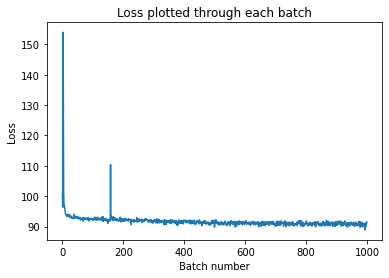

In [5]:
# Plotting the loss through the epochs
plt.plot(loss_list)
#plt.scatter(range(len(loss_list)), loss_list)
plt.title("Loss plotted through each batch")
plt.ylabel("Loss")
plt.xlabel("Batch number")
#plt.yscale("log")
#plt.xscale("log")
plt.savefig("loss_log.png")

In [6]:
# Predicting
accuracies = []
with torch.no_grad():
    # Loading saved model from file
    model.load_state_dict(torch.load("model.pth"))
    #model.eval()

    # Initalising data generator
    dataset = Dataset(small_file, max_seq_len, acids=acids)
    base_generator = data.DataLoader(dataset, batch_size=32, shuffle=True, num_workers=8)

    correct = 0
    
    # For loops is easiest way to get an element from
    # the generator even though we only loop once
    for i, (batch, labels, valid_elems) in enumerate(base_generator):
        test = batch
        batch = batch.to(processor)
        labels = labels.to(processor)

        # Transposing from (batch x seq x feature_size) to (seq x batch x feature_size)
        batch = batch.transpose(0,1)
        #labels = torch.transpose(labels, 0, 1)

        batch = rnn.pack_padded_sequence(batch, valid_elems, enforce_sorted=False)

        out, hidden = model(batch)

        out = out.transpose(0,1)

        print(out.size())
        print(valid_elems.size())
        for j in range(batch_size):
            preds = torch.argmax(out[j], dim=1)[:valid_elems[j]]
            actual = labels[j][:valid_elems[j]]
            truths = [1 if pred == truth else 0 for pred, truth in zip(preds, actual)]
            correct += sum(truths)
        accuracy = correct/(torch.sum(valid_elems).item())
        break
    
print(accuracy)
print(labels.size())

#print(torch.argmax(out[0], dim=1))
#print(torch.max(out[0,:10], dim=1))
print(torch.argmax(out[0,:10], dim=1))
#print(out[0,:10])

print_seq(out[0].view(1,2000,23), valid_elems)
print_seq(test[0].view(1,2000,23), valid_elems)


torch.Size([32, 2000, 23])
torch.Size([32])


0.11338692764767563
torch.Size([32, 2000])
tensor([16,  9,  9,  9,  9,  9,  9,  9,  9,  9], device='cuda:0')
Sequence 0
SLLLLLLLLLLLLLLLLLLLLKLLLLKLLKLLLKLLKKLLKLLLKLLKLLKDSKKKLLLLLLLLLLKKLKLKKIIKDGKKKKKKKLKKLKKKKKKKKDKLKKLLKKKLLLLLLLLLSLSSSILKDKLKLSKLLKKLLKKKLDSLILLDLLIIIIIIDSLIIIIILDKLLKKLIKKKDDGKIIIILDGLIIIIIIIIIIIIIIKKNKKKKIIIIIIIIIIIIIIIKKIIKKIIIIKGKIIIIIIIIIKKKKIKIIKIIIII-
Sequence 0
MLTILKLGGSILSDKNVPYSIKWDNLERIAMEIKNALDYYKNQNKEIKLILVHGGGAFGHPVAKKYLKIEDGKKIFINMEKGFWEIQRAMRRFNNIIIDTLQSYDIPAVSIQPSSFVVFGDKLIFDTSAIKEMLKRNLVPVIHGDIVIDDKNGYRIISGDDIVPYLANELKADLILYATDVDGVLIDNKPIKRIDKNNIYKILNYLSGSNSIDVTGGMKYKIDMIRKNKCRGFVFNGNKANNIYKALLGEVEGTEIDFSE-
